# H12 locus artwork 

## Setup

In [1]:
%run locus-artwork-setup.ipynb

In [2]:
def plot_h12_percentiles(pop):
    fig, ax = plt.subplots(facecolor='w', figsize=(10, 3))
    
    # plot each chromosome
    x = np.arange(80, 100)
    all_h12s = []
    for c in '2', '3', 'X':
        # load gwss data
        _, _, _, h12, _, _ = load_h12_gwss(pop, c)
        all_h12s.append(h12)
        # plot 
        y = [np.percentile(h12, i) for i in x]
        ax.plot(x, y, marker='o', label=c)
        
    # plot all
    h12 = np.concatenate(all_h12s)
    y = [np.percentile(h12, i) for i in x]
    ax.plot(x, y, marker='o', label='all', color='k', lw=2)

    # tidy
    ax.set_ylim(bottom=0, top=0.4)
    ax.legend(loc='upper left', title='Chromosome')
    ax.set_xticks(x)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('$H12$')
    ax.set_title(pop_defs[pop]['label'])
    
    plt.show()
    plt.close()
    

In [3]:
@functools.lru_cache(maxsize=None)
def get_h12_percentile(pop, q):
    h12s = []
    for c in '2', '3', 'X':
        # load gwss data
        _, _, _, h12, _, _ = load_h12_gwss(pop, c)
        h12s.append(h12)
    h12 = np.concatenate(h12s)
    return np.percentile(h12, q)
    

In [4]:
get_h12_percentile('bf_gam', 99)

0.162943052930056

In [5]:
get_h12_percentile('bf_gam', 98)

0.09913120962352417

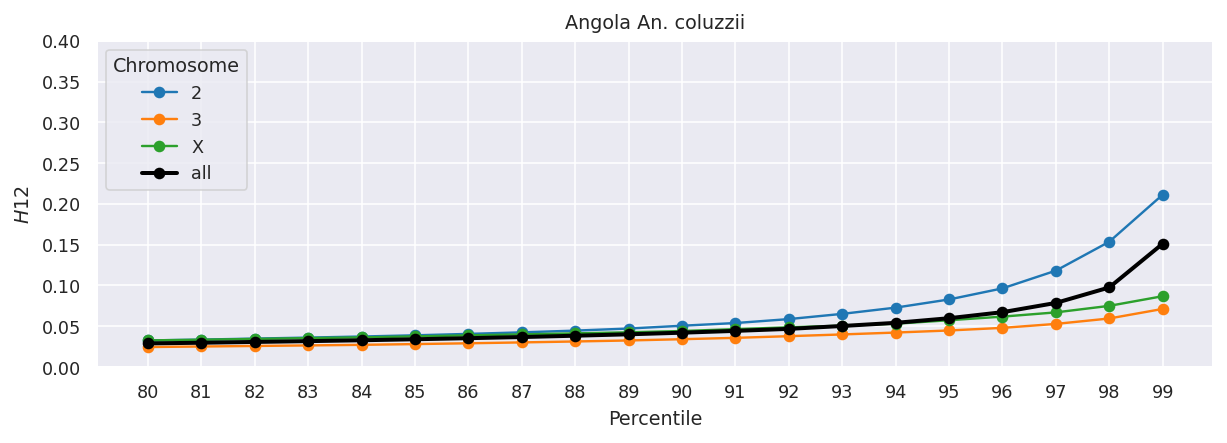

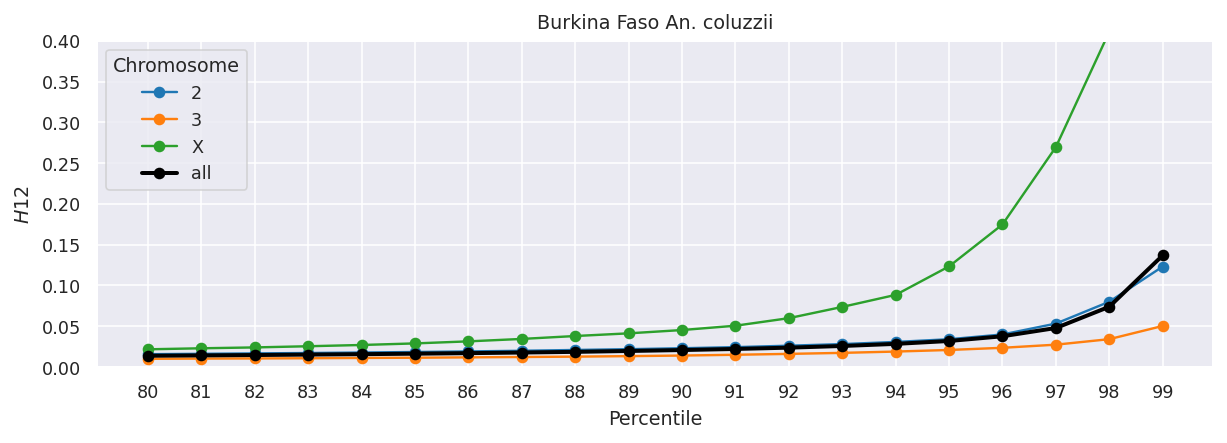

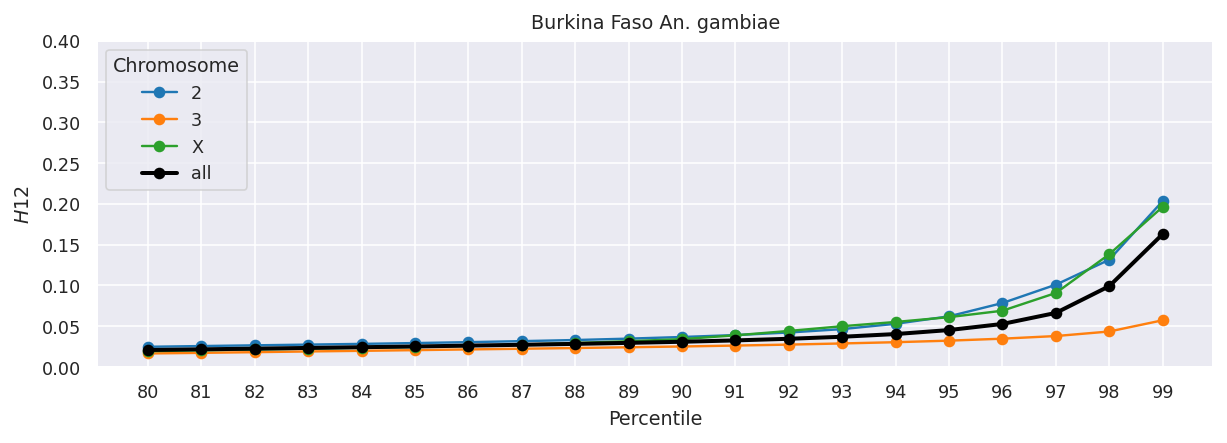

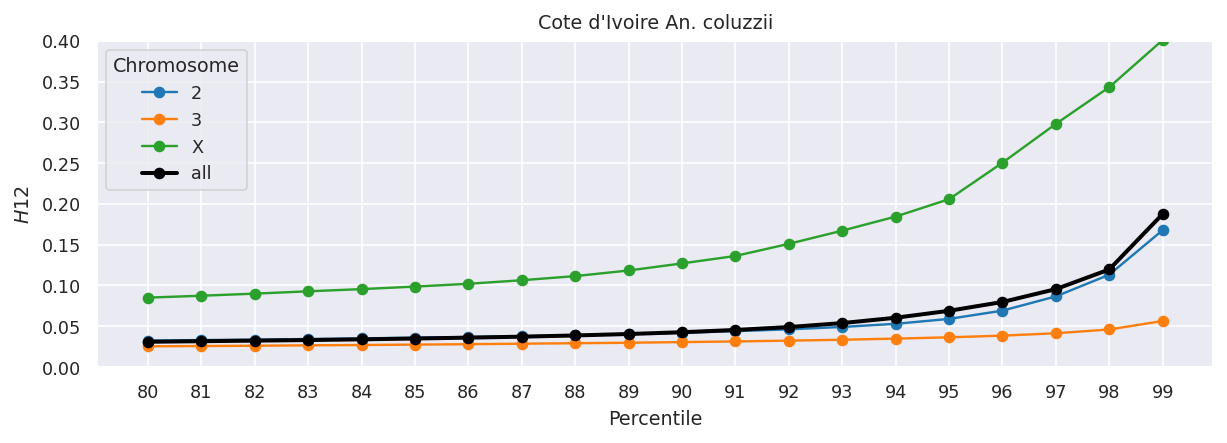

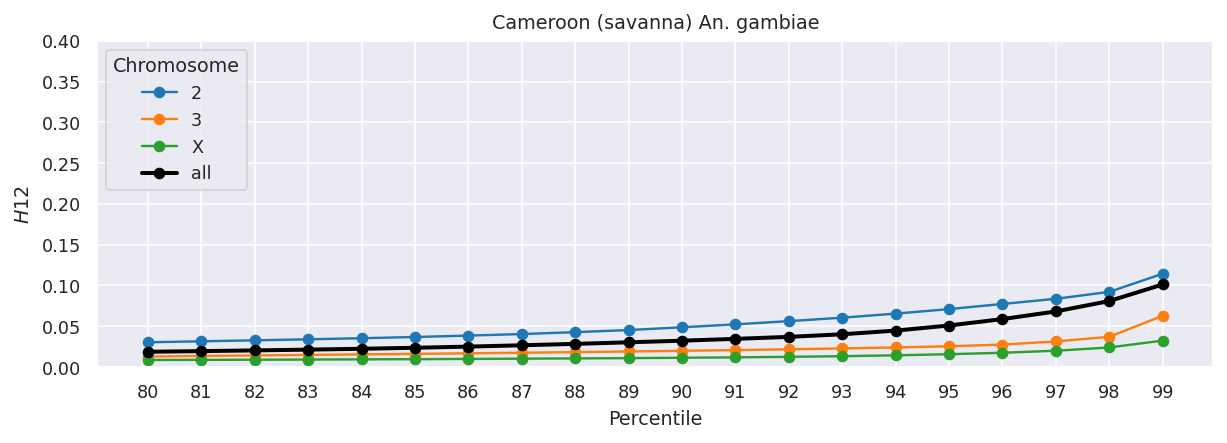

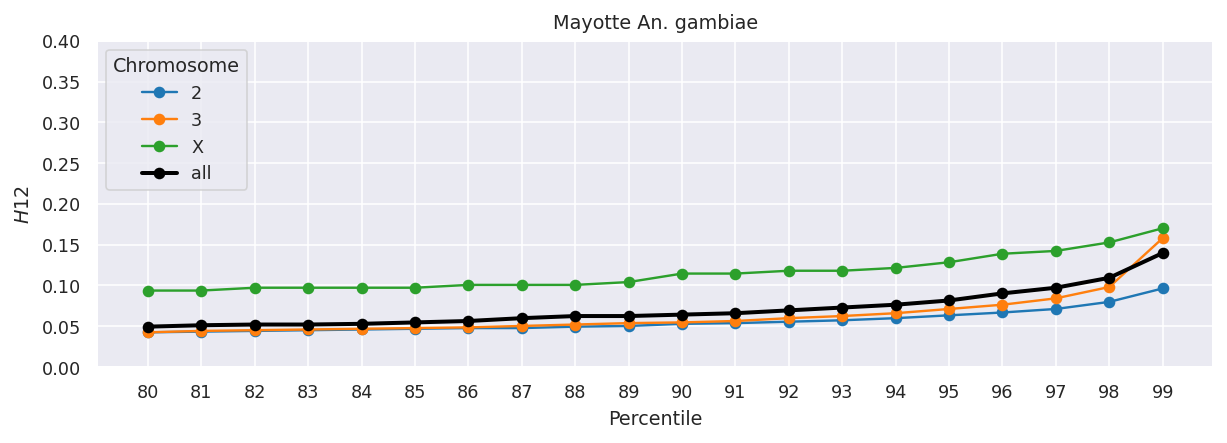

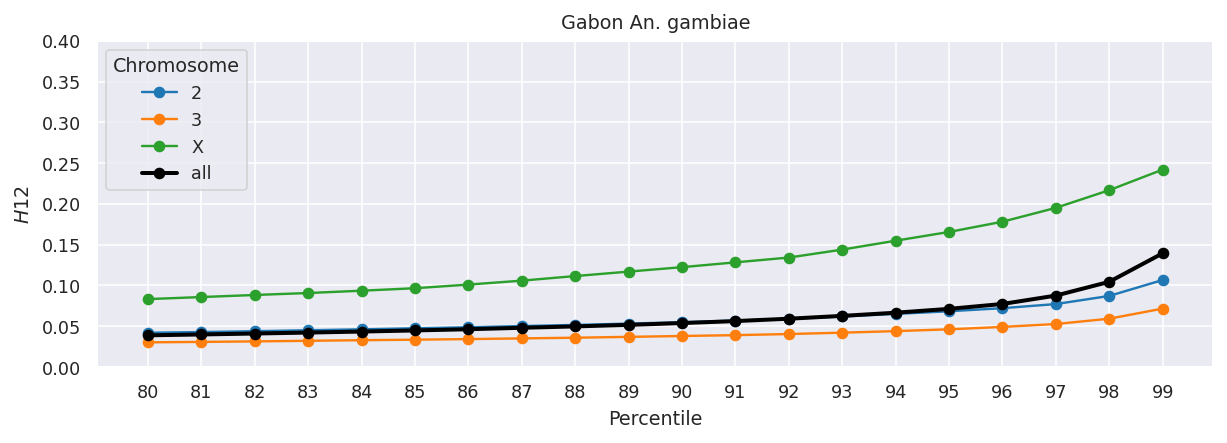

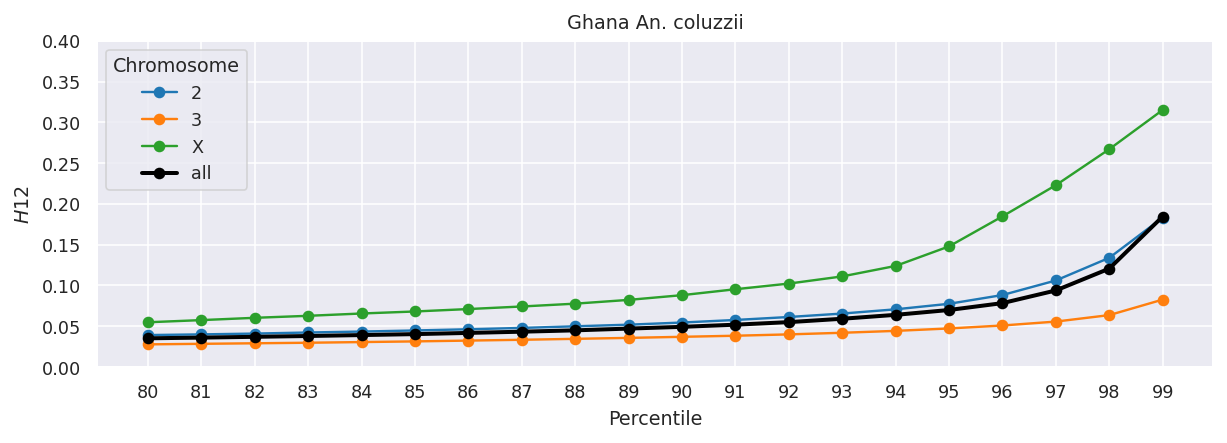

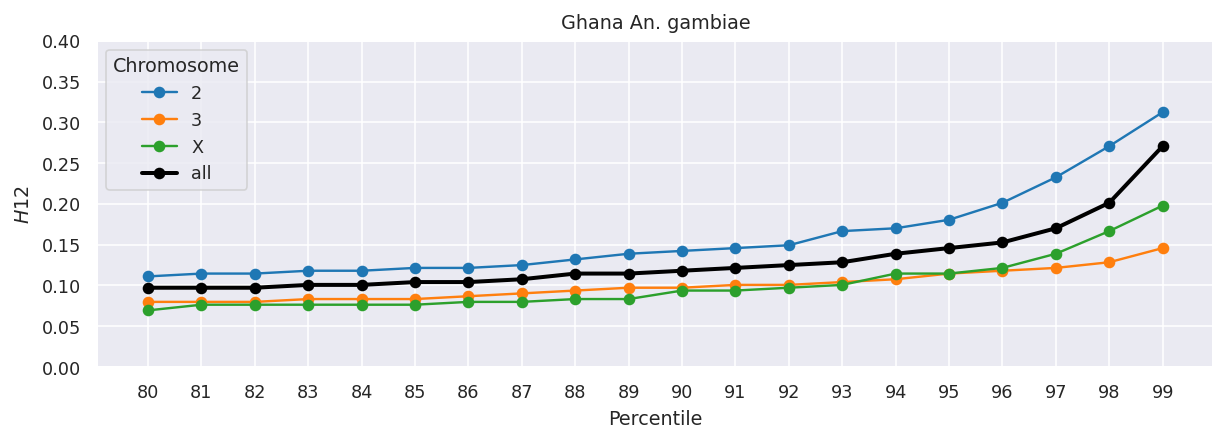

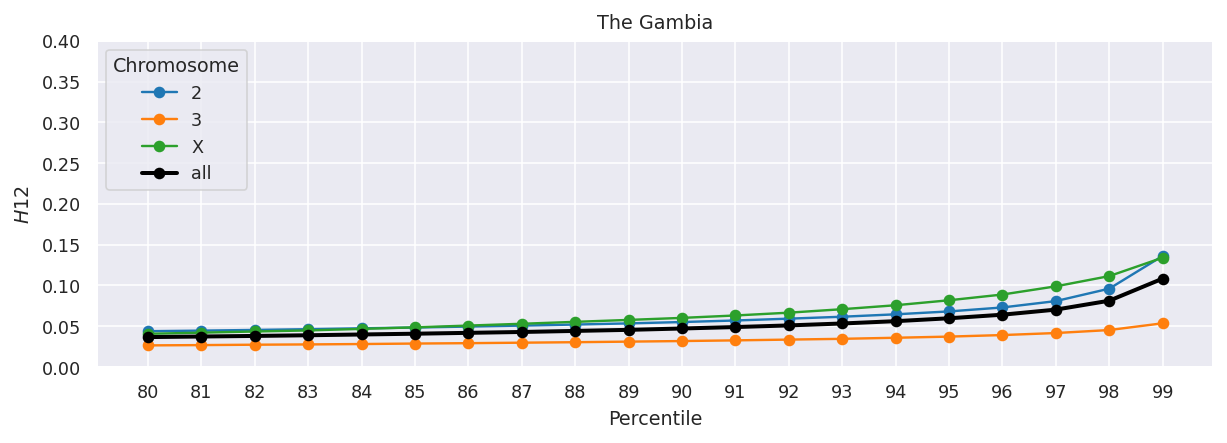

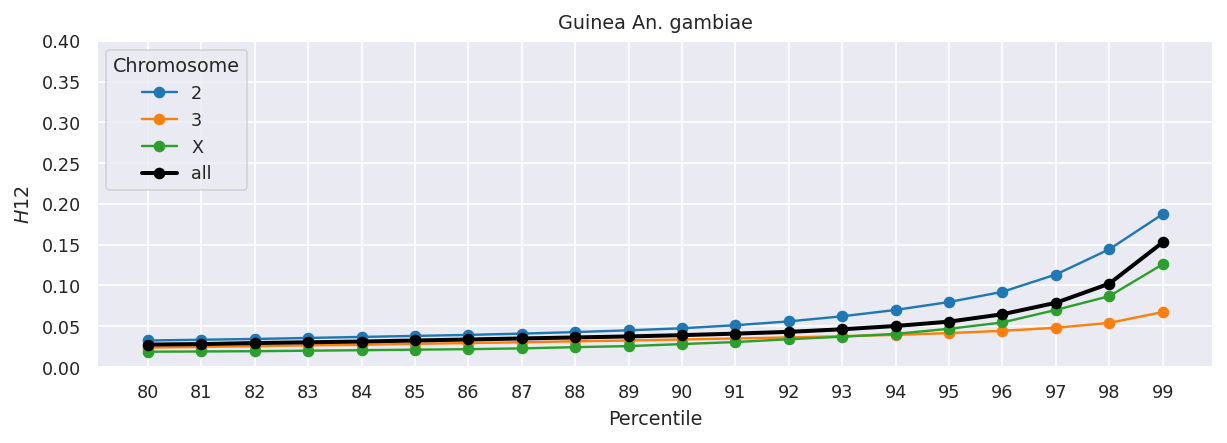

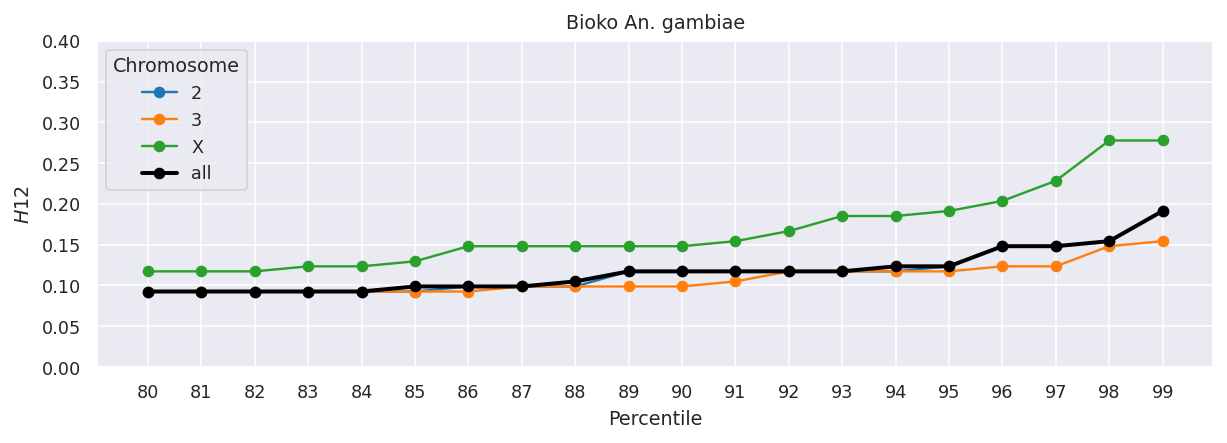

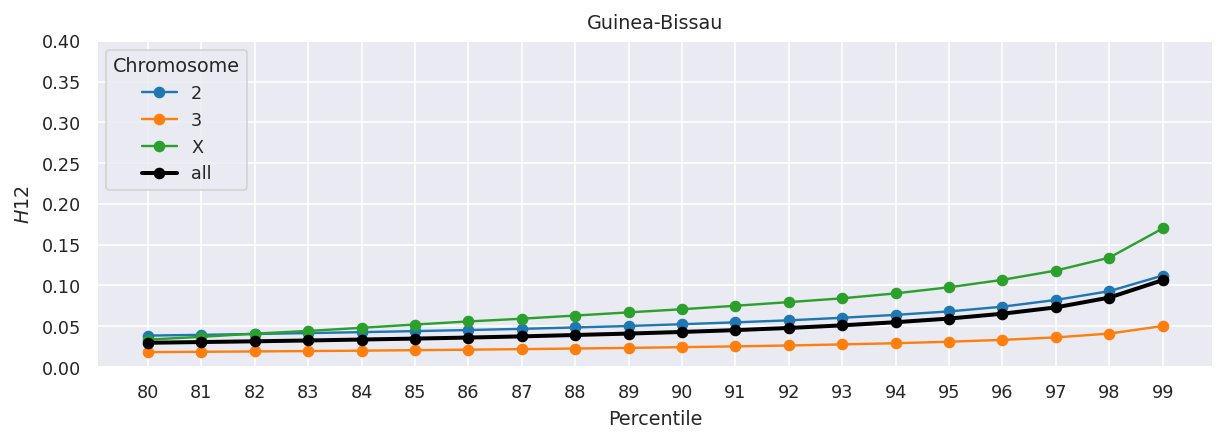

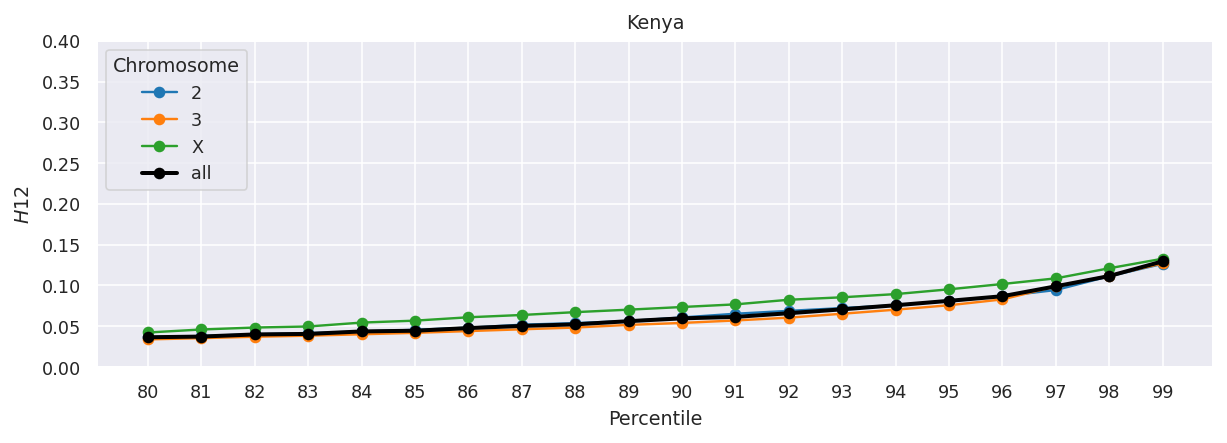

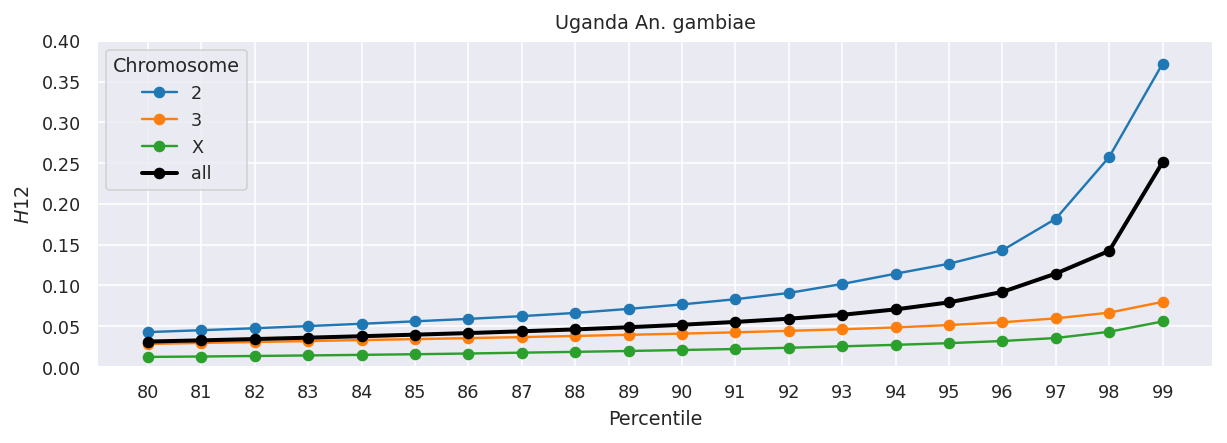

In [6]:
for pop in pop_defs:
    plot_h12_percentiles(pop)

In [7]:
def plot_h12(pop, chromosome, center, flank, ymax=None, ax=None, step=1, shift=0, 
             markersize=3, legend=False, genetic_distance=False, label=True, detail=False,
             median_filter=0, has_peak_windows=20):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
        
    # load gwss data
    windows, gwindows, h1, h12, h123, h2_h1 = load_h12_gwss(pop, chromosome)
    if median_filter:
        h12 = scipy.ndimage.median_filter(h12, size=median_filter, mode='wrap')
    p = windows.mean(axis=1)/1e6
    gp = gwindows.mean(axis=1)
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p
        
    # plot percentile
    t99 = get_h12_percentile(pop, 99)
#     ax.axhline(t99, color='gray', linestyle='--', lw=1)
    t98 = get_h12_percentile(pop, 98)
    ax.axhline(t98, color='gray', linestyle='--', lw=1)
    ax.annotate('$P_{98}$', xy=(xlim[1], t98), xytext=(2, 0), xycoords='data', 
                textcoords='offset points', ha='left', va='center', fontsize=8)
#     t95 = get_h12_percentile(pop, 95)
#     ax.axhline(t95, color='gray', linestyle='--', lw=1)
    
    # plot data
    if detail:
        palette = sns.color_palette("Blues_d", 3)
        ax.plot(x[shift::step], h123[shift::step], linestyle=' ', marker='o', color=palette[2], 
                markersize=markersize, label='$H123$')
        ax.plot(x[shift::step], h12[shift::step], linestyle=' ', marker='o', color=palette[1], 
                markersize=markersize, label='$H12$')
        ax.plot(x[shift::step], h1[shift::step], linestyle=' ', marker='o', color=palette[0], 
                markersize=markersize, label='$H1$')
    else:
        palette = sns.color_palette()
        ax.plot(x[shift::step], h12[shift::step], linestyle=' ', marker='o', color=palette[0], 
                markersize=markersize, label='$H12$')

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        if detail:
            ymax = max(1.1*t99, 1.1*np.max(h123[loc_xlim]))
        else:
            ymax = max(1.1*t99, 1.1*np.max(h12[loc_xlim]))
    ax.set_ylim(0, ymax)
    ax.set_ylabel('$H12$')
    pop_label = (
        pop_defs[pop]["label"]
        .replace('An. gambiae', '$An. gambiae$')
        .replace('An. coluzzii', '$An. coluzzii$')
    )
    
    # statistics
    loc_peak_test = allel.SortedIndex(p).locate_range(center-.2, center+.2)
    has_peak = call_peak(h12[loc_peak_test], t98, has_peak_windows)
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-.5, center+.5)
        h1_peak = np.max(h1[loc_region])
        h12_peak = np.max(h12[loc_region])
        h123_peak = np.max(h123[loc_region])
        pos_h1_peak = p[loc_region][np.argmax(h1[loc_region])] - center
        pos_h12_peak = p[loc_region][np.argmax(h12[loc_region])] - center
        pos_h123_peak = p[loc_region][np.argmax(h123[loc_region])] - center
        statistics = dict(
            pop=pop,
            h1_peak=h1_peak,
            h12_peak=h12_peak,
            h123_peak=h123_peak,
            pos_h1_peak=pos_h1_peak,
            pos_h12_peak=pos_h12_peak,
            pos_h123_peak=pos_h123_peak
        )
    else:
        statistics = dict(
            pop=pop,
            h1_peak=np.nan,
            h12_peak=np.nan,
            h123_peak=np.nan,
            pos_h1_peak=np.nan,
            pos_h12_peak=np.nan,
            pos_h123_peak=np.nan
        )
    
    if label:
        if has_peak:
            if detail:
                annotation = (
                    f"{pop_label}\n"
                    f"$H123_{{peak}}={h123_peak:.2f}$\n"
                    f"$H12_{{peak}}={h12_peak:.2f}$\n"
                    f"$H1_{{peak}}={h1_peak:.2f}$\n"
                    f"$pos(H12_{{peak}})={pos_h12_peak*1e3:+.1f}$ kbp"
                )
            else:
                annotation = (
                    f"{pop_label}\n"
                    f"$H12_{{peak}}={h12_peak:.2f}$\n"
                    f"$pos(H12_{{peak}})={pos_h12_peak*1e3:+.1f}$ kbp"
                )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xycoords='axes fraction',
                    xytext=(8, -8), textcoords='offset points', 
                    fontsize=8, ha='left', va='top', backgroundcolor='w')
    if detail and legend:
        lgd = ax.legend(bbox_to_anchor=(1, 1), loc='upper right', facecolor='w', edgecolor='w')
        for handle in lgd.legendHandles:
            handle._legmarker.set_markersize(6)
            
    return statistics
    

## *Gste2*

In [8]:
gste2

seqid                            3R
source                   VectorBase
type                           gene
start                      28597652
end                        28598640
score                            -1
strand                            -
phase                            -1
Name                          Gste2
biotype              protein_coding
chromosome                        3
chromosome_start           28597652
chromosome_end             28598640
chromosome_center       2.85981e+07
Name: AGAP009194, dtype: object

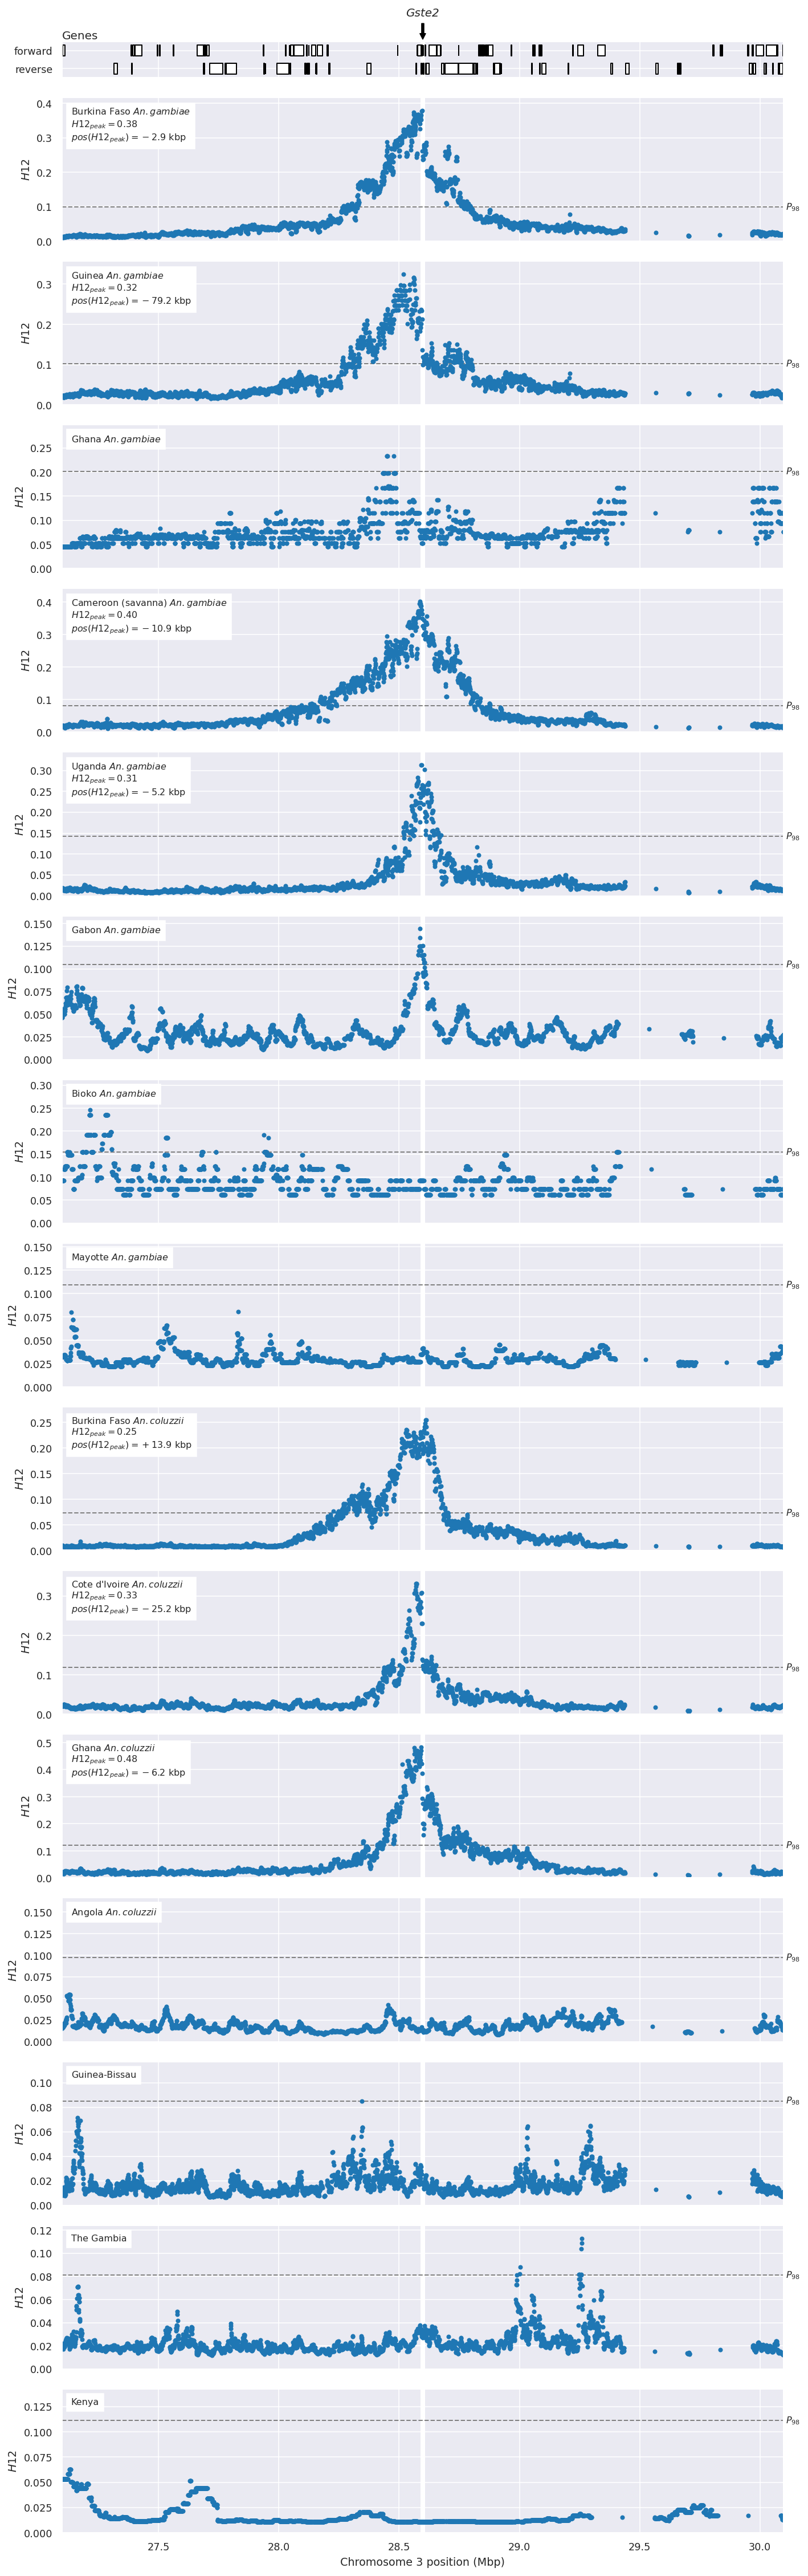

In [9]:
df_stats_gste2 = fig_locus(
    chromosome=gste2.chromosome, center=gste2.chromosome_center/1e6, 
    flank=1.5, label=gste2['Name'], track_height=2,
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
        (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
        (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
        (plot_h12, dict(pop='ke')),
    ),
)

In [10]:
df_stats_gste2

pop   h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  \
0       bf_gam  0.265832  0.378958   0.578509    -0.037545     -0.002928   
1       gn_gam  0.232188  0.324688   0.385000    -0.079232     -0.079232   
2       gh_gam       NaN       NaN        NaN          NaN           NaN   
3   cm_sav_gam  0.296495  0.401638   0.460286    -0.010877     -0.010877   
4       ug_gam  0.252750  0.312500   0.371811     0.006885     -0.005205   
5       ga_gam       NaN       NaN        NaN          NaN           NaN   
6       gq_gam       NaN       NaN        NaN          NaN           NaN   
7       fr_gam       NaN       NaN        NaN          NaN           NaN   
8       bf_col  0.229422  0.254667   0.324356     0.013875      0.013875   
9       ci_col  0.210375  0.331482   0.387721    -0.027389     -0.025225   
10      gh_col  0.249917  0.482645   0.558017    -0.006162     -0.006162   
11      ao_col       NaN       NaN        NaN          NaN           NaN   
12          gw       NaN       NaN        NaN          NaN           NaN   
13          gm       NaN       NaN        NaN          NaN           NaN   
14          ke       NaN       NaN        NaN          NaN           NaN   

    pos_h123_peak  locus  
0       -0.005205  Gste2  
1       -0.037545  Gste2  
2             NaN  Gste2  
3       -0.019050  Gste2  
4       -0.005205  Gste2  
5             NaN  Gste2  
6             NaN  Gste2  
7             NaN  Gste2  
8       -0.068910  Gste2  
9       -0.025225  Gste2  
10      -0.024061  Gste2  
11            NaN  Gste2  
12            NaN  Gste2  
13            NaN  Gste2  
14            NaN  Gste2

In [11]:
df_stats_gste2.describe().loc[['count', 'min', 'max']]

h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  pos_h123_peak
count  7.000000  7.000000   7.000000     7.000000      7.000000       7.000000
min    0.210375  0.254667   0.324356    -0.079232     -0.079232      -0.068910
max    0.296495  0.482645   0.578509     0.013875      0.013875      -0.005205

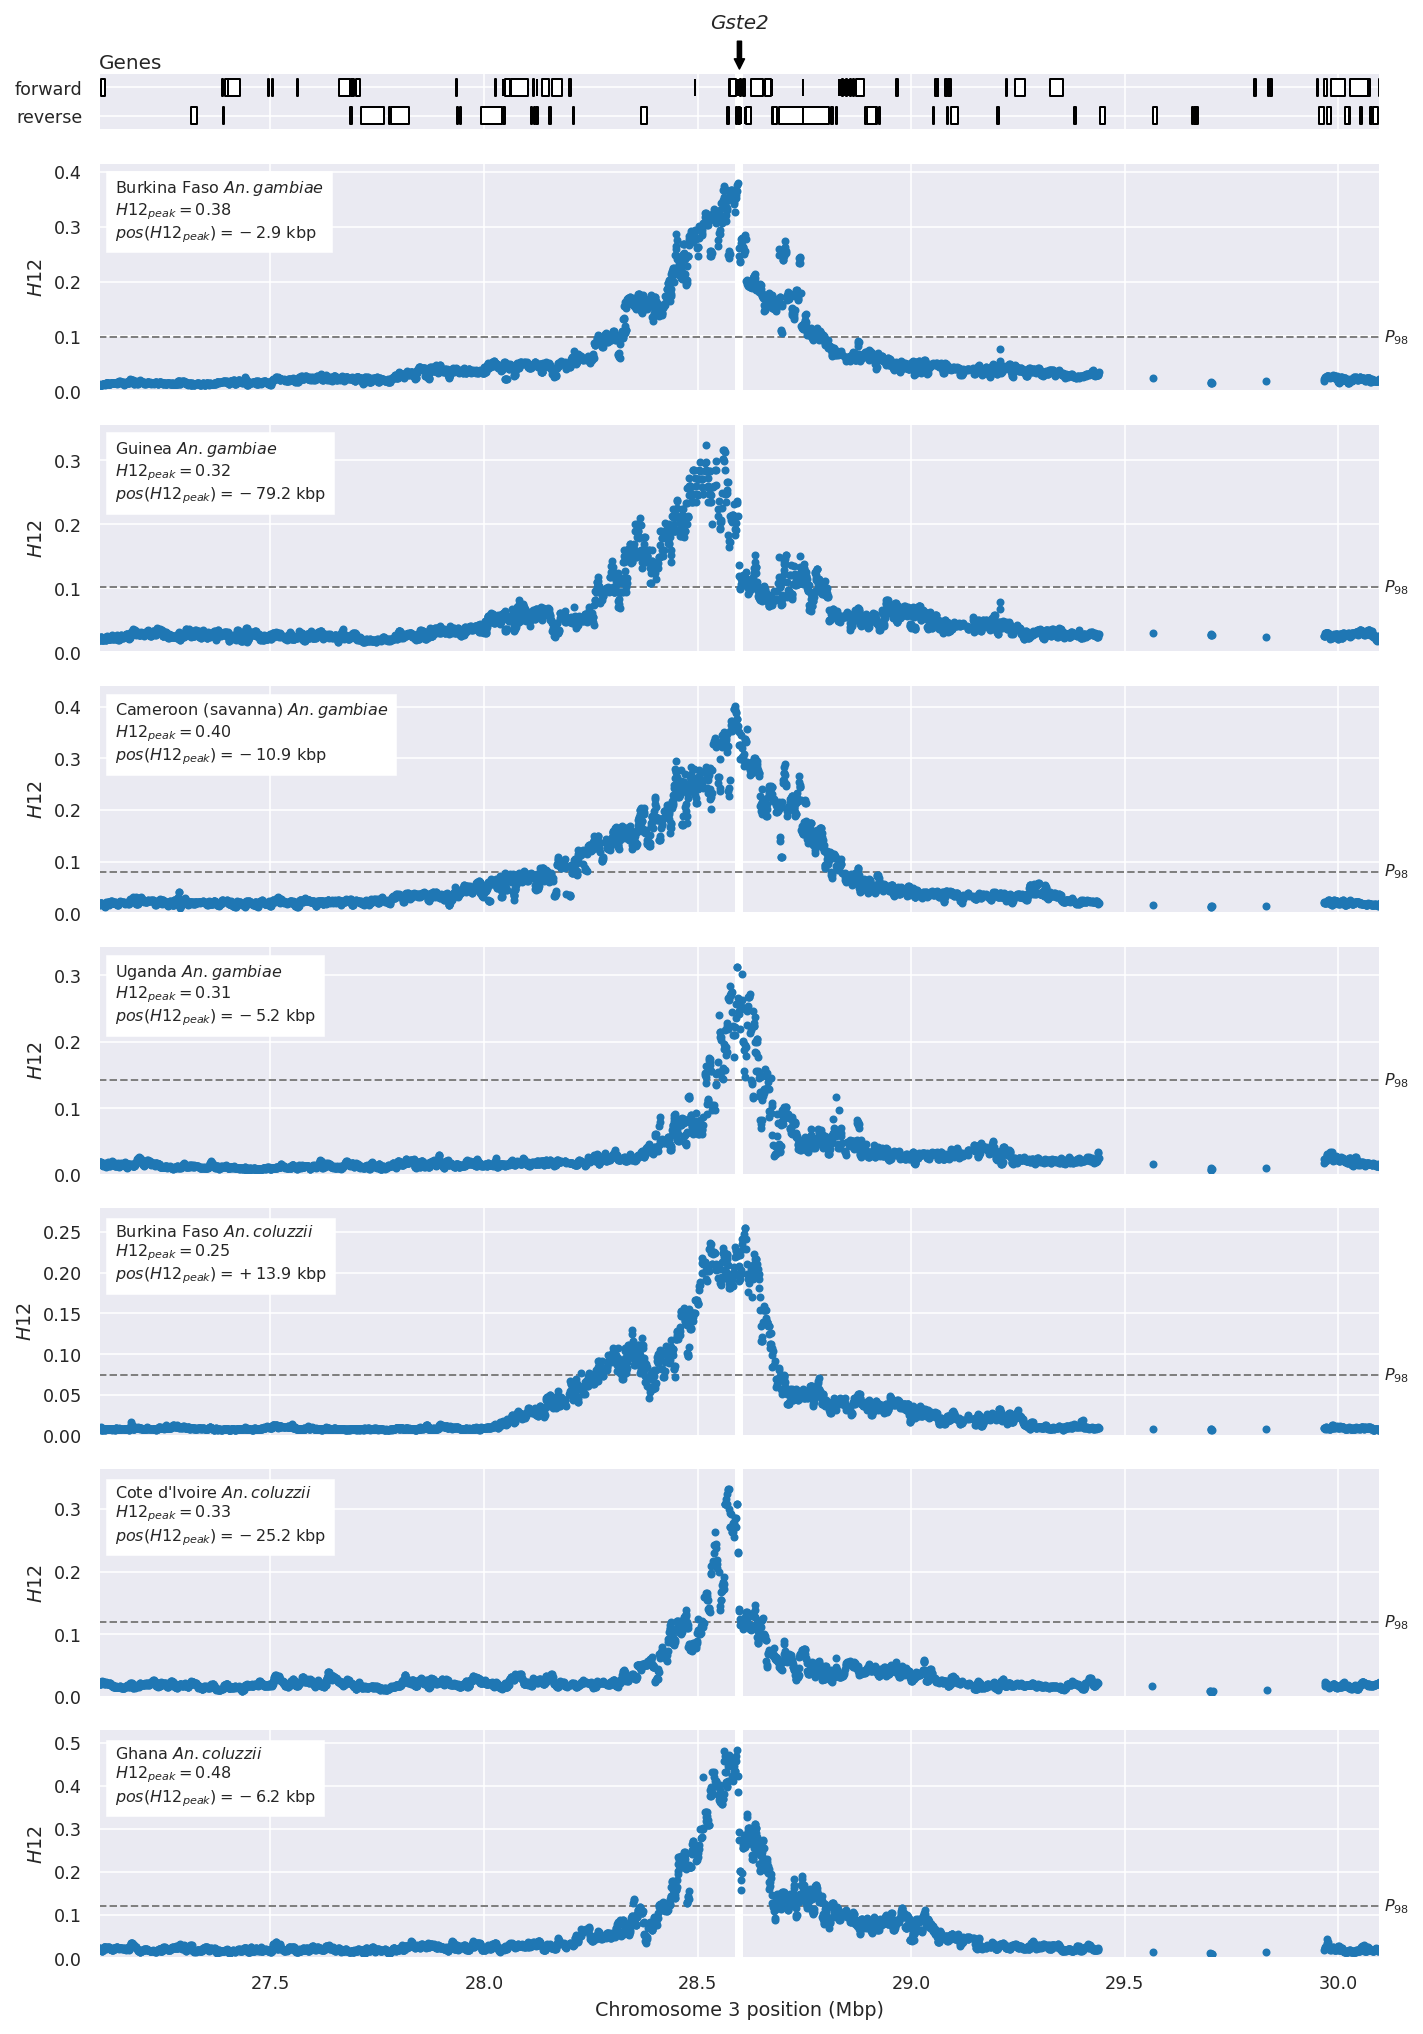

In [12]:
fig_locus(
    chromosome=gste2.chromosome, center=gste2.chromosome_center/1e6, 
    flank=1.5, label=gste2['Name'],
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
#         (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
#         (plot_h12, dict(pop='ga_gam')),
#         (plot_h12, dict(pop='gq_gam')),
#         (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
#         (plot_h12, dict(pop='ao_col')),
#         (plot_h12, dict(pop='gw')),
#         (plot_h12, dict(pop='gm')),
#         (plot_h12, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_gste2_h12.png'
);

## *Cyp6p3*

In [13]:
cyp6p3

seqid                            2R
source                   VectorBase
type                           gene
start                      28491415
end                        28493141
score                            -1
strand                            -
phase                            -1
Name                         Cyp6p3
biotype              protein_coding
chromosome                        2
chromosome_start           28491415
chromosome_end             28493141
chromosome_center       2.84923e+07
Name: AGAP002865, dtype: object

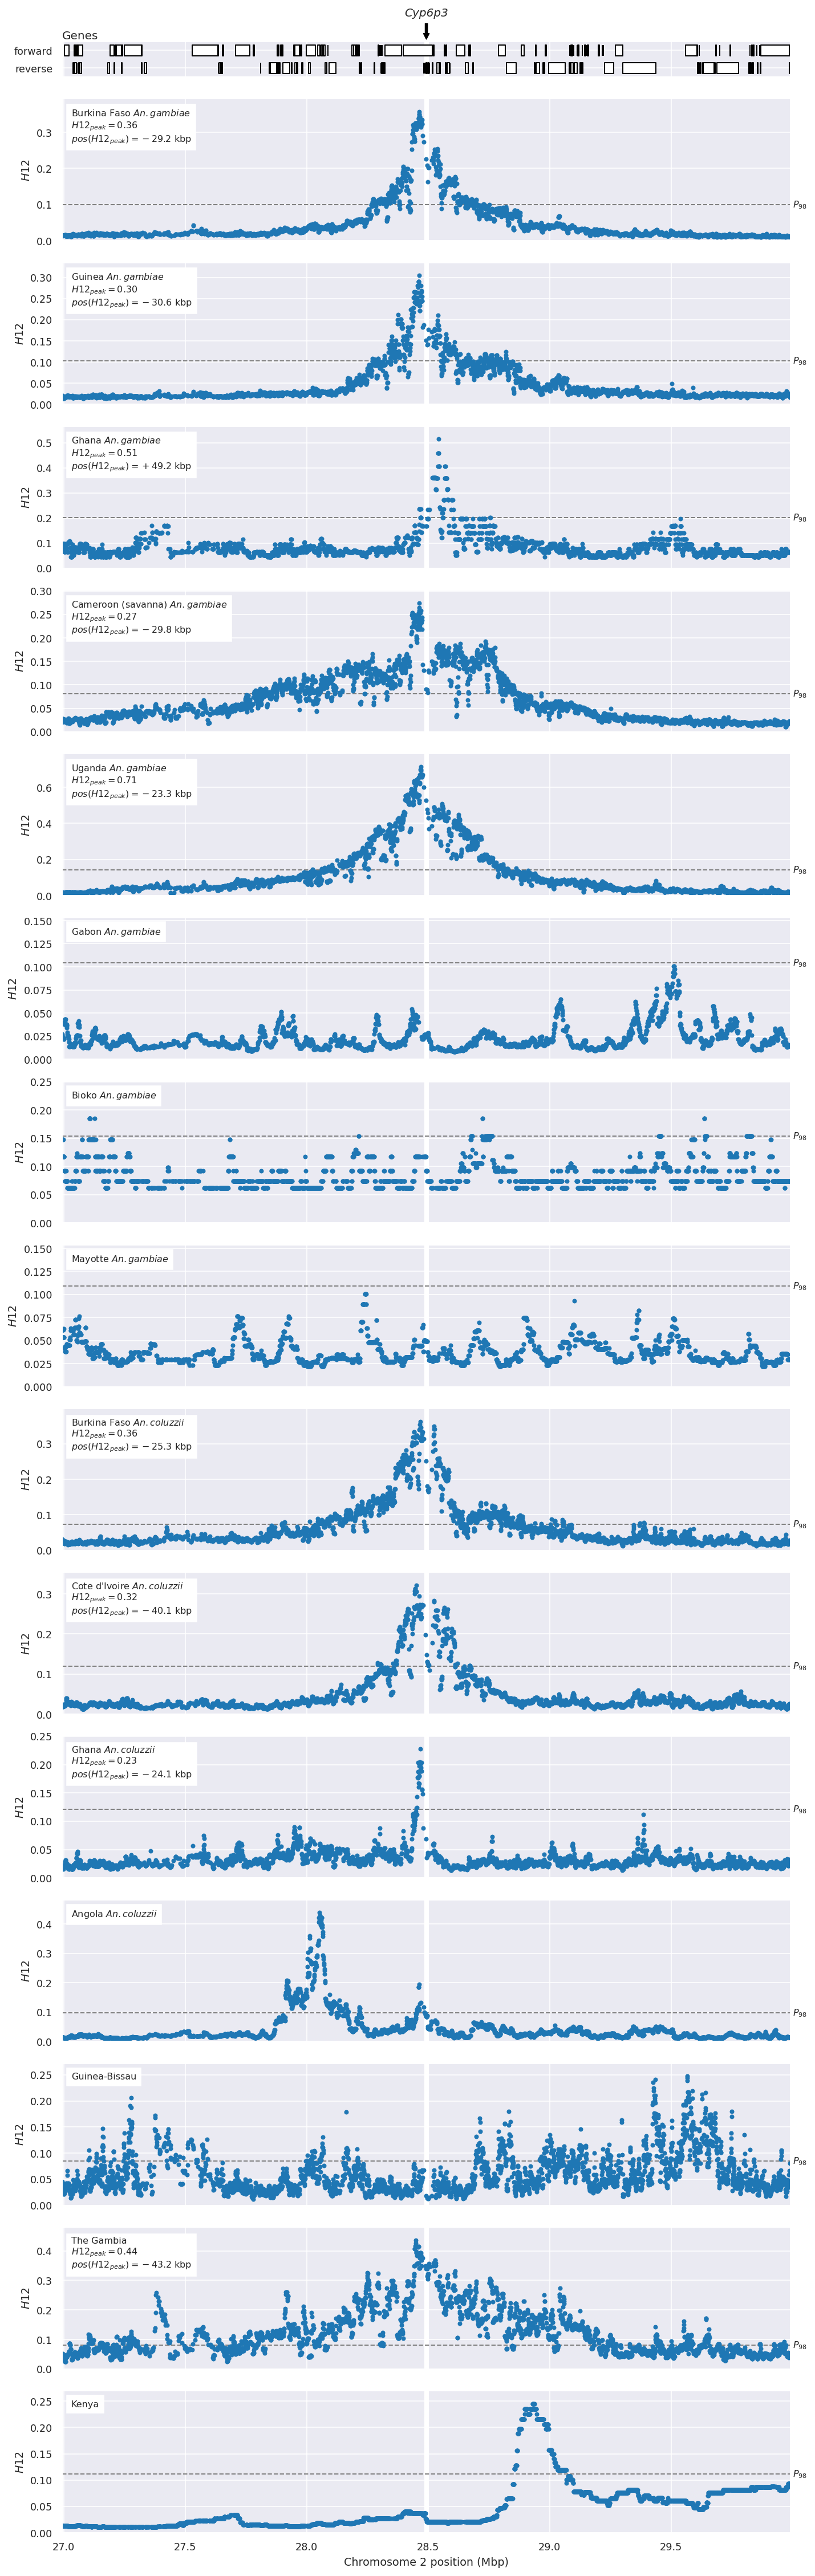

In [14]:
df_stats_cyp6p3 = fig_locus(
    chromosome=cyp6p3.chromosome, center=cyp6p3.chromosome_center/1e6, 
    flank=1.5, label=cyp6p3['Name'], track_height=2,
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
        (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
        (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
        (plot_h12, dict(pop='ke')),
    ),
)

In [15]:
df_stats_cyp6p3

pop   h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  \
0       bf_gam  0.223712  0.356628   0.536508    -0.029163     -0.029163   
1       gn_gam  0.177500  0.304375   0.398438    -0.030594     -0.030594   
2       gh_gam  0.284722  0.513889   0.572917     0.049171      0.049171   
3   cm_sav_gam  0.141385  0.274360   0.296061    -0.029828     -0.029828   
4       ug_gam  0.433793  0.714326   0.774593    -0.023295     -0.023295   
5       ga_gam       NaN       NaN        NaN          NaN           NaN   
6       gq_gam       NaN       NaN        NaN          NaN           NaN   
7       fr_gam       NaN       NaN        NaN          NaN           NaN   
8       bf_col  0.186489  0.362311   0.433511    -0.025300     -0.025300   
9       ci_col  0.214640  0.321762   0.430073    -0.040121     -0.040121   
10      gh_col  0.176694  0.227603   0.278182    -0.024114     -0.024114   
11      ao_col       NaN       NaN        NaN          NaN           NaN   
12          gw       NaN       NaN        NaN          NaN           NaN   
13          gm  0.363669  0.436568   0.506982    -0.043211     -0.043211   
14          ke       NaN       NaN        NaN          NaN           NaN   

    pos_h123_peak   locus  
0       -0.029163  Cyp6p3  
1       -0.030594  Cyp6p3  
2        0.049171  Cyp6p3  
3       -0.029828  Cyp6p3  
4       -0.023295  Cyp6p3  
5             NaN  Cyp6p3  
6             NaN  Cyp6p3  
7             NaN  Cyp6p3  
8       -0.025300  Cyp6p3  
9       -0.040121  Cyp6p3  
10      -0.024114  Cyp6p3  
11            NaN  Cyp6p3  
12            NaN  Cyp6p3  
13      -0.043211  Cyp6p3  
14            NaN  Cyp6p3

In [16]:
df_stats_cyp6p3.describe().loc[['count', 'min', 'max']]

h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  pos_h123_peak
count  9.000000  9.000000   9.000000     9.000000      9.000000       9.000000
min    0.141385  0.227603   0.278182    -0.043211     -0.043211      -0.043211
max    0.433793  0.714326   0.774593     0.049171      0.049171       0.049171

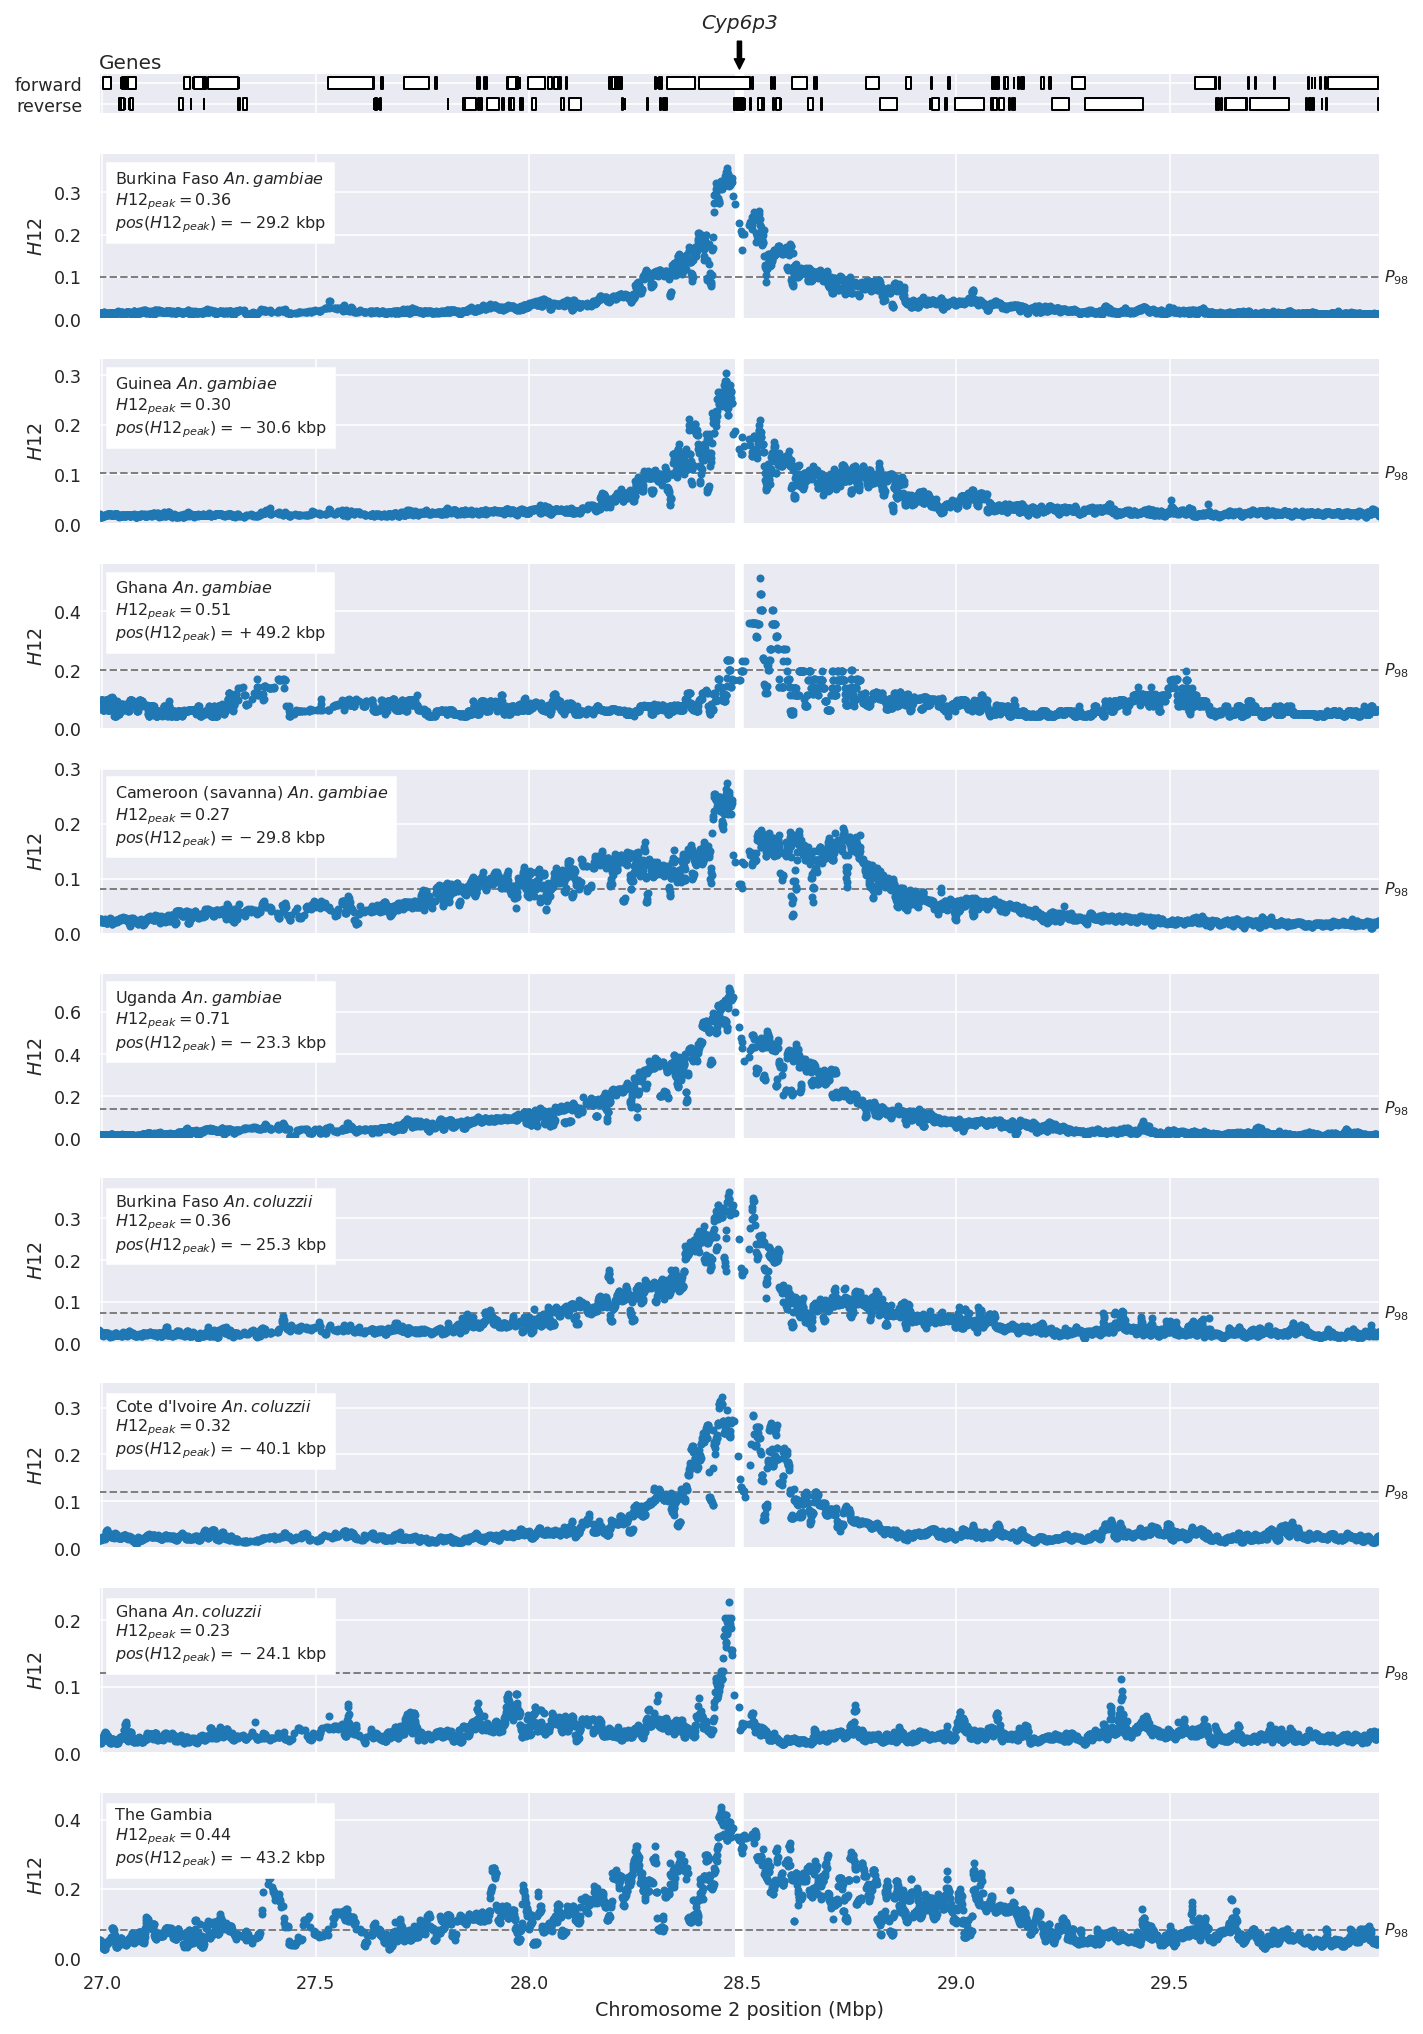

In [17]:
fig_locus(
    chromosome=cyp6p3.chromosome, center=cyp6p3.chromosome_center/1e6, 
    flank=1.5, label=cyp6p3['Name'],
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
#         (plot_h12, dict(pop='ga_gam')),
#         (plot_h12, dict(pop='gq_gam')),
#         (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
#         (plot_h12, dict(pop='ao_col')),
#         (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
#         (plot_h12, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_cyp6p3_h12.png'
);

## *Vgsc*

In [18]:
vgsc

seqid                            2L
source                   VectorBase
type                           gene
start                       2358158
end                         2431617
score                            -1
strand                            +
phase                            -1
Name                           Vgsc
biotype              protein_coding
chromosome                        2
chromosome_start           63903263
chromosome_end             63976722
chromosome_center         6.394e+07
Name: AGAP004707, dtype: object

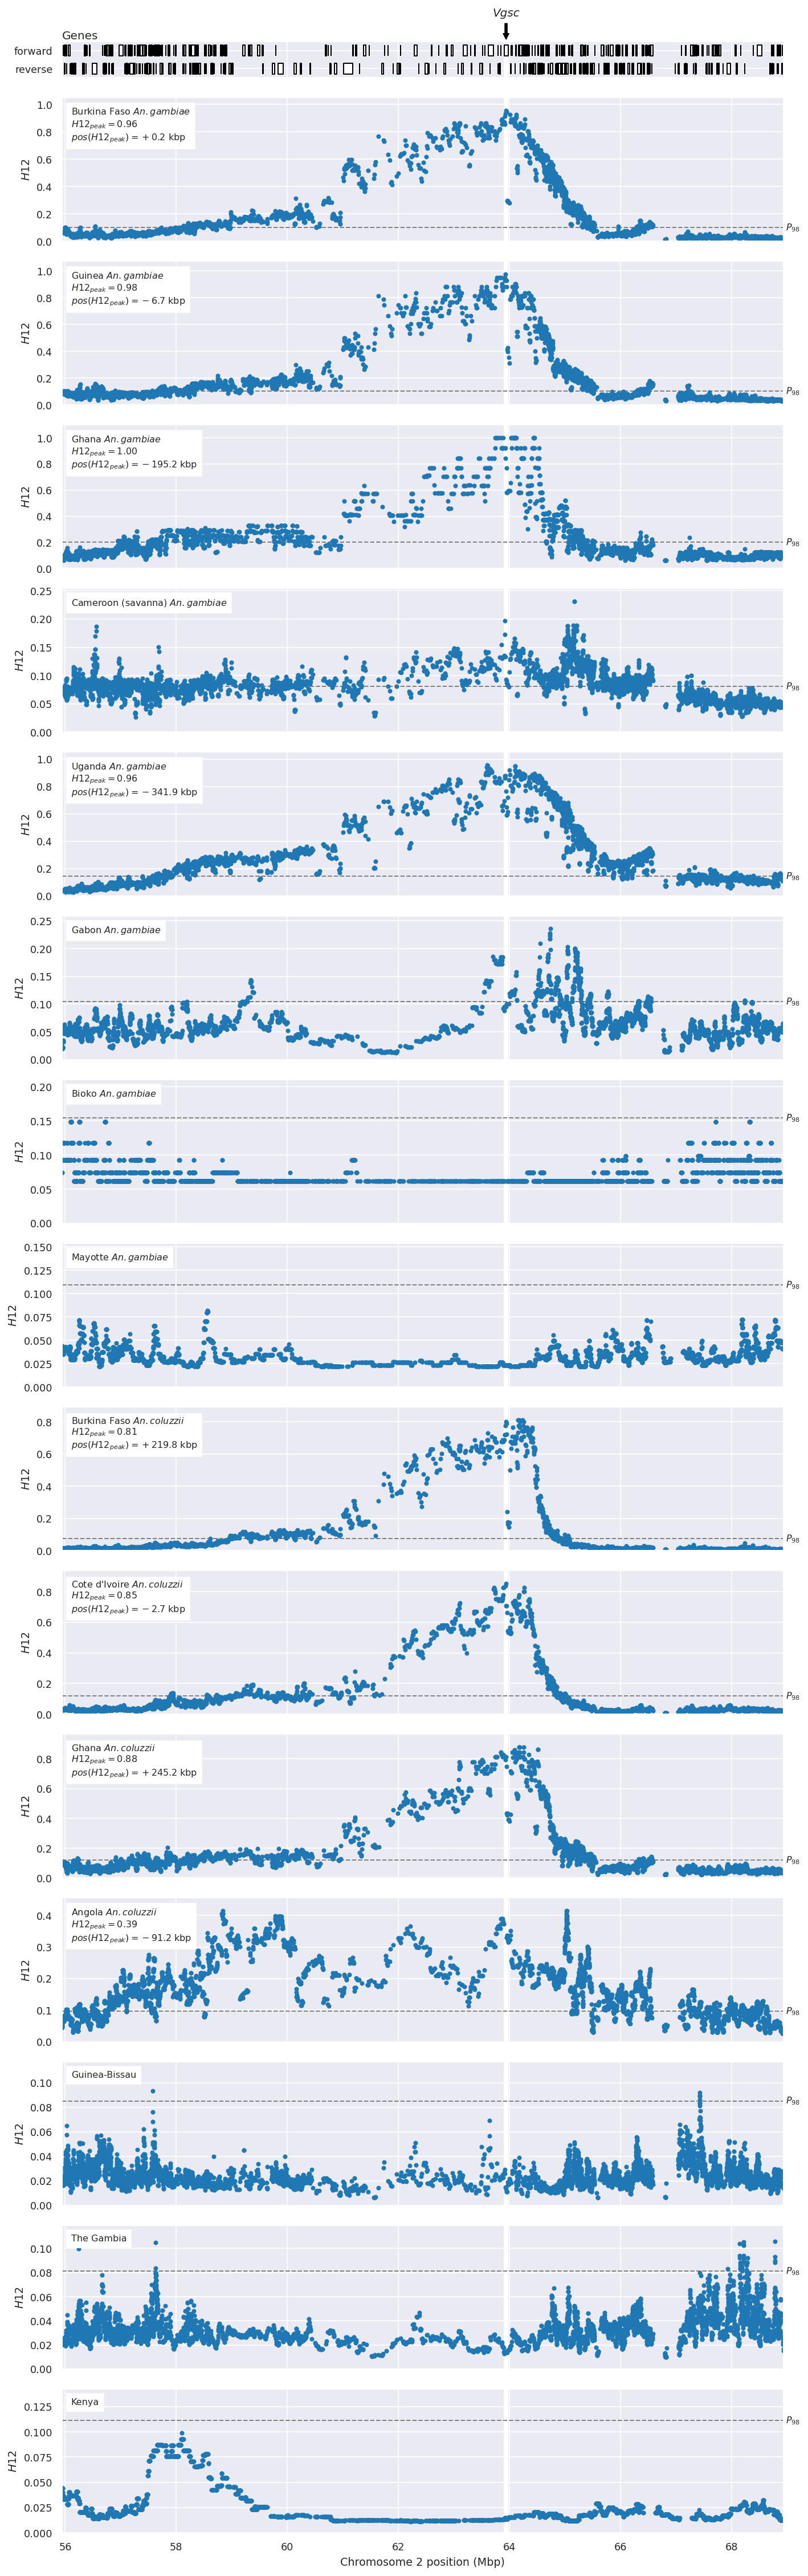

In [19]:
df_stats_vgsc = fig_locus(
    chromosome=vgsc.chromosome, center=vgsc.chromosome_center/1e6, 
    flank=(8, 5), label=vgsc['Name'], track_height=2, 
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
        (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
        (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
        (plot_h12, dict(pop='ke')),
    ),
)

In [20]:
df_stats_vgsc

pop   h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  \
0       bf_gam  0.946538  0.957112   0.967746     0.000217      0.000217   
1       gn_gam  0.950937  0.975312   1.000000    -0.006749     -0.006749   
2       gh_gam  1.000000  1.000000   1.000000    -0.195197     -0.195197   
3   cm_sav_gam       NaN       NaN        NaN          NaN           NaN   
4       ug_gam  0.479711  0.955955   0.964684    -0.341929     -0.341929   
5       ga_gam       NaN       NaN        NaN          NaN           NaN   
6       gq_gam       NaN       NaN        NaN          NaN           NaN   
7       fr_gam       NaN       NaN        NaN          NaN           NaN   
8       bf_col  0.700711  0.811022   0.884089     0.000217      0.219787   
9       ci_col  0.741222  0.851617   0.864610    -0.216511     -0.002666   
10      gh_col  0.680000  0.877521   0.911736    -0.058568      0.245202   
11      ao_col  0.330539  0.389053   0.397025    -0.091210     -0.091210   
12          gw       NaN       NaN        NaN          NaN           NaN   
13          gm       NaN       NaN        NaN          NaN           NaN   
14          ke       NaN       NaN        NaN          NaN           NaN   

    pos_h123_peak locus  
0        0.000217  Vgsc  
1       -0.006749  Vgsc  
2       -0.195197  Vgsc  
3             NaN  Vgsc  
4       -0.341929  Vgsc  
5             NaN  Vgsc  
6             NaN  Vgsc  
7             NaN  Vgsc  
8        0.000217  Vgsc  
9       -0.002666  Vgsc  
10       0.259389  Vgsc  
11      -0.091210  Vgsc  
12            NaN  Vgsc  
13            NaN  Vgsc  
14            NaN  Vgsc

In [21]:
df_stats_vgsc.describe().loc[['count', 'min', 'max']]

h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  pos_h123_peak
count  8.000000  8.000000   8.000000     8.000000      8.000000       8.000000
min    0.330539  0.389053   0.397025    -0.341929     -0.341929      -0.341929
max    1.000000  1.000000   1.000000     0.000217      0.245202       0.259389

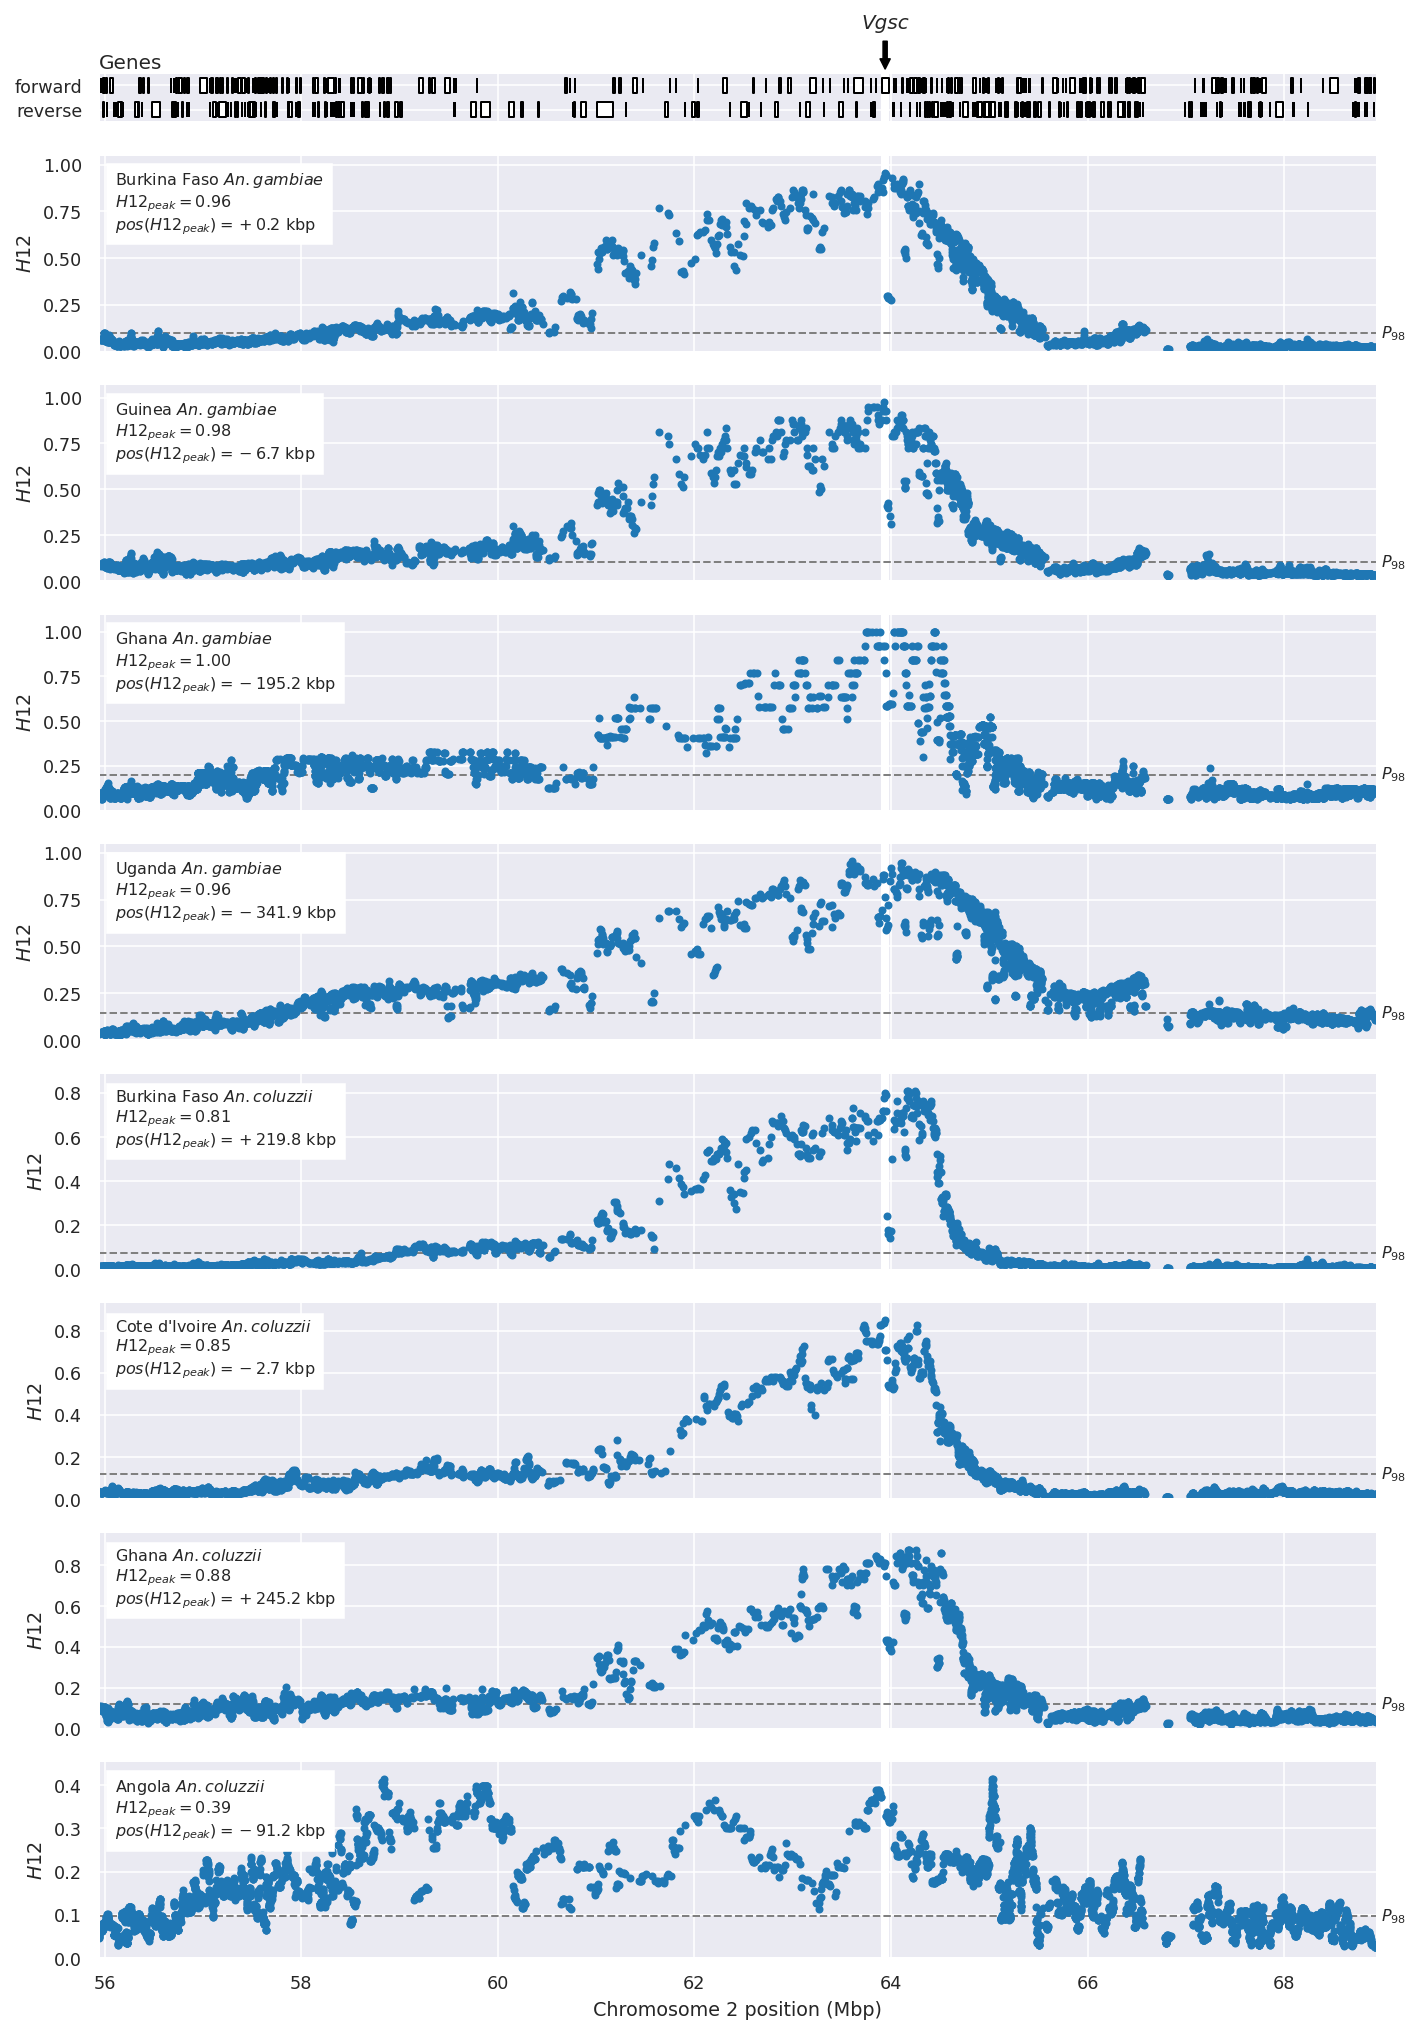

In [22]:
fig_locus(
    chromosome=vgsc.chromosome, center=vgsc.chromosome_center/1e6, 
    flank=(8, 5), label=vgsc['Name'],
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
#         (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
#         (plot_h12, dict(pop='ga_gam')),
#         (plot_h12, dict(pop='gq_gam')),
#         (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
#         (plot_h12, dict(pop='gw')),
#         (plot_h12, dict(pop='gm')),
#         (plot_h12, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_vgsc_h12_pdist.png'
);

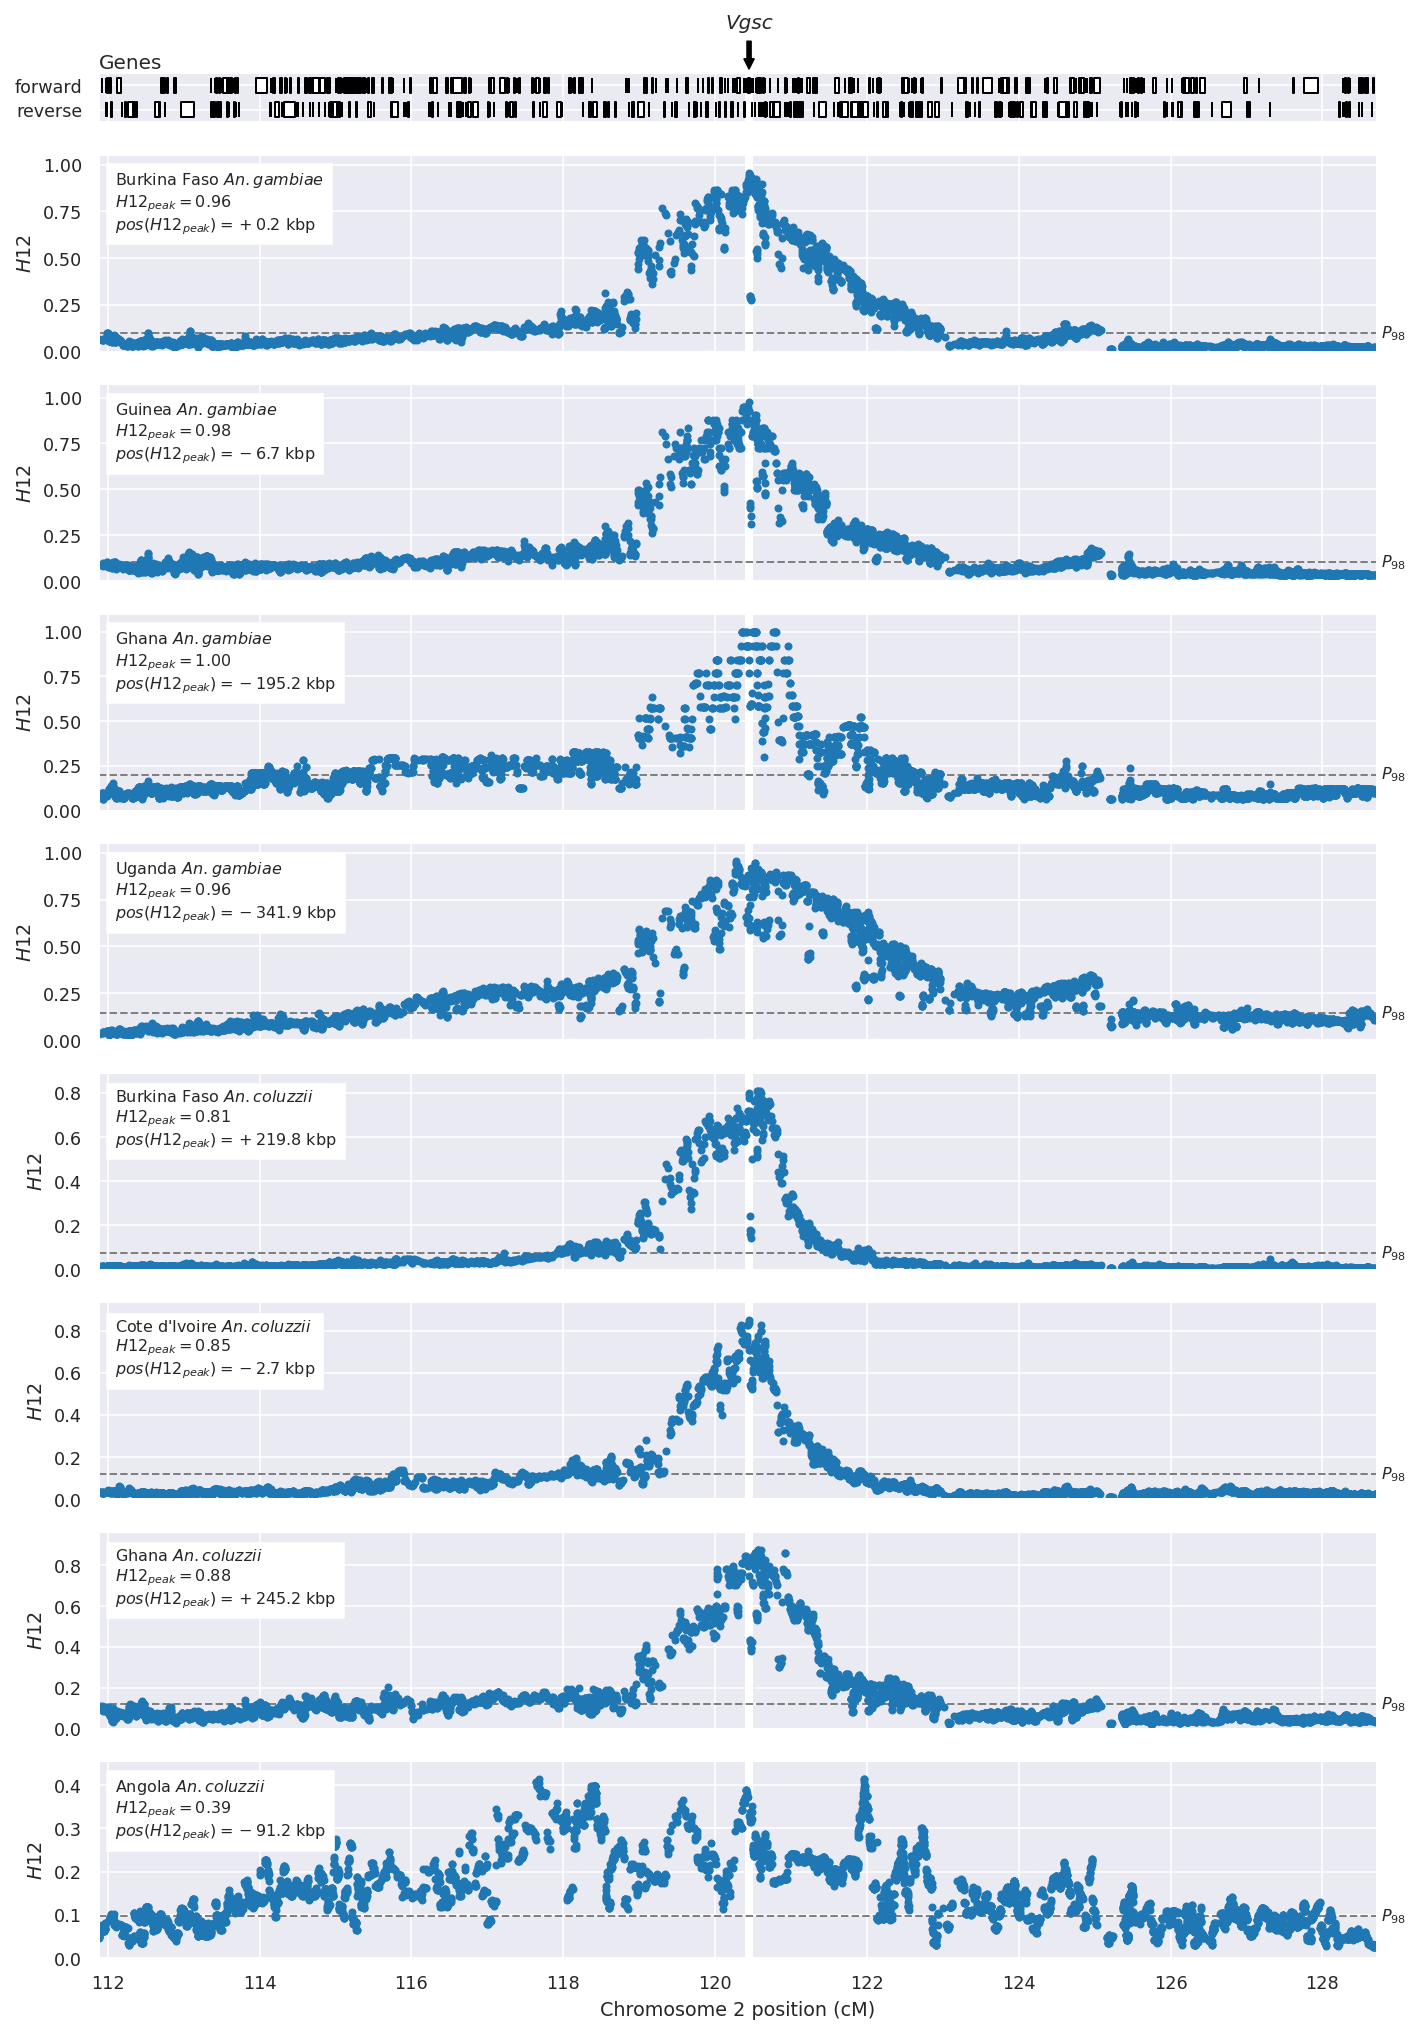

In [23]:
fig_locus(
    chromosome=vgsc.chromosome, center=vgsc.chromosome_center/1e6, 
    flank=(8, 5), label=vgsc['Name'], genetic_distance=True,
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
#         (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
#         (plot_h12, dict(pop='ga_gam')),
#         (plot_h12, dict(pop='gq_gam')),
#         (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
#         (plot_h12, dict(pop='gw')),
#         (plot_h12, dict(pop='gm')),
#         (plot_h12, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_vgsc_h12_gdist.png'
);

## *Gaba*

In [24]:
gaba

seqid                            2L
source                   VectorBase
type                           gene
start                      25363652
end                        25434556
score                            -1
strand                            +
phase                            -1
Name                           Gaba
biotype              protein_coding
chromosome                        2
chromosome_start           86908757
chromosome_end             86979661
chromosome_center       8.69442e+07
Name: AGAP006028, dtype: object

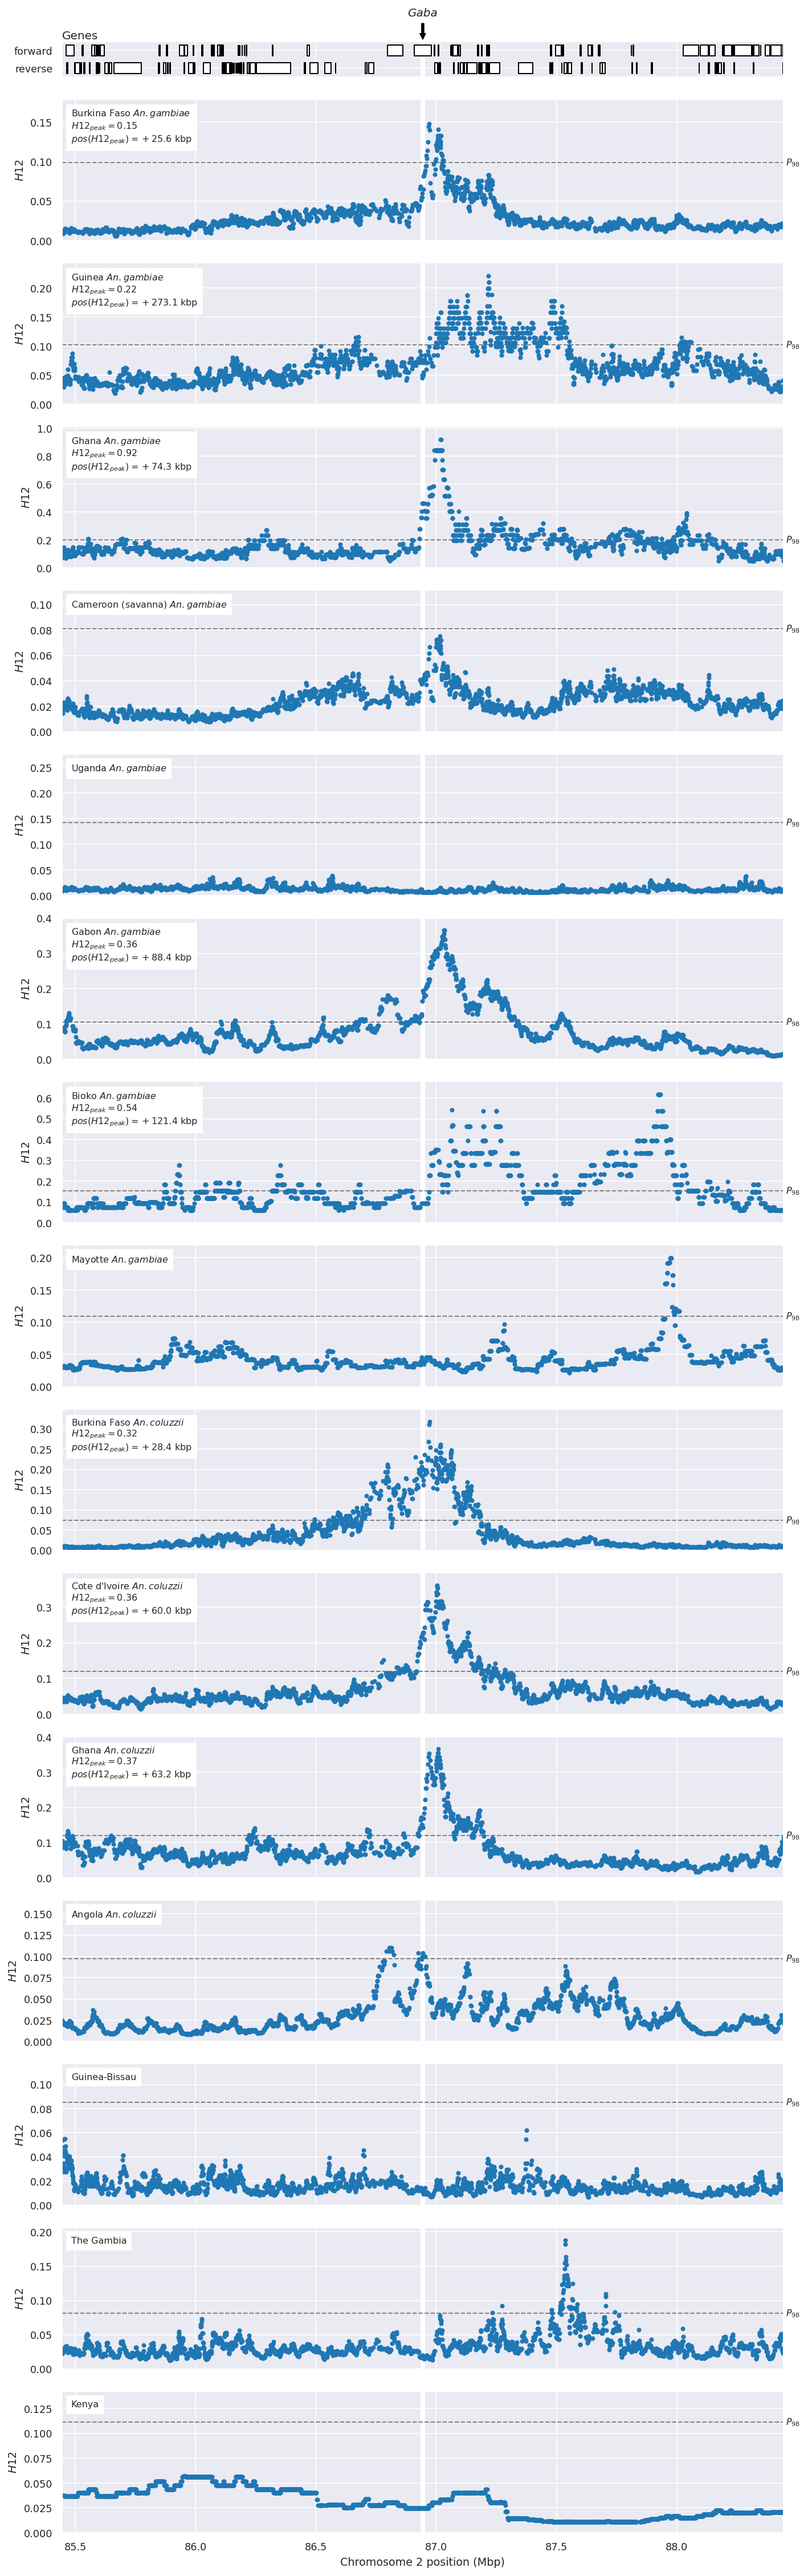

In [25]:
df_stats_gaba = fig_locus(
    chromosome=gaba.chromosome, center=gaba.chromosome_center/1e6, 
    flank=1.5, label=gaba['Name'], track_height=2,
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
        (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
        (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
        (plot_h12, dict(pop='ke')),
    ),
)

In [26]:
df_stats_gaba

pop   h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  \
0       bf_gam  0.140064  0.148098   0.161094     0.025600      0.025600   
1       gn_gam  0.189375  0.221250   0.244375     0.273126      0.273126   
2       gh_gam  0.843750  0.920139   1.000000     0.074328      0.074328   
3   cm_sav_gam       NaN       NaN        NaN          NaN           NaN   
4       ug_gam       NaN       NaN        NaN          NaN           NaN   
5       ga_gam  0.339635  0.364839   0.382273     0.088421      0.088421   
6       gq_gam  0.401235  0.543210   0.703704     0.305567      0.121394   
7       fr_gam       NaN       NaN        NaN          NaN           NaN   
8       bf_col  0.289244  0.317689   0.347556     0.028408      0.028408   
9       ci_col  0.270780  0.360048   0.451696     0.019944      0.059986   
10      gh_col  0.324793  0.365785   0.398843     0.063196      0.063196   
11      ao_col       NaN       NaN        NaN          NaN           NaN   
12          gw       NaN       NaN        NaN          NaN           NaN   
13          gm       NaN       NaN        NaN          NaN           NaN   
14          ke       NaN       NaN        NaN          NaN           NaN   

    pos_h123_peak locus  
0        0.064695  Gaba  
1        0.273126  Gaba  
2        0.074328  Gaba  
3             NaN  Gaba  
4             NaN  Gaba  
5        0.088421  Gaba  
6        0.121394  Gaba  
7             NaN  Gaba  
8        0.028408  Gaba  
9        0.059986  Gaba  
10       0.062485  Gaba  
11            NaN  Gaba  
12            NaN  Gaba  
13            NaN  Gaba  
14            NaN  Gaba

In [27]:
df_stats_gaba.describe().loc[['count', 'min', 'max']]

h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  pos_h123_peak
count  8.000000  8.000000   8.000000     8.000000      8.000000       8.000000
min    0.140064  0.148098   0.161094     0.019944      0.025600       0.028408
max    0.843750  0.920139   1.000000     0.305567      0.273126       0.273126

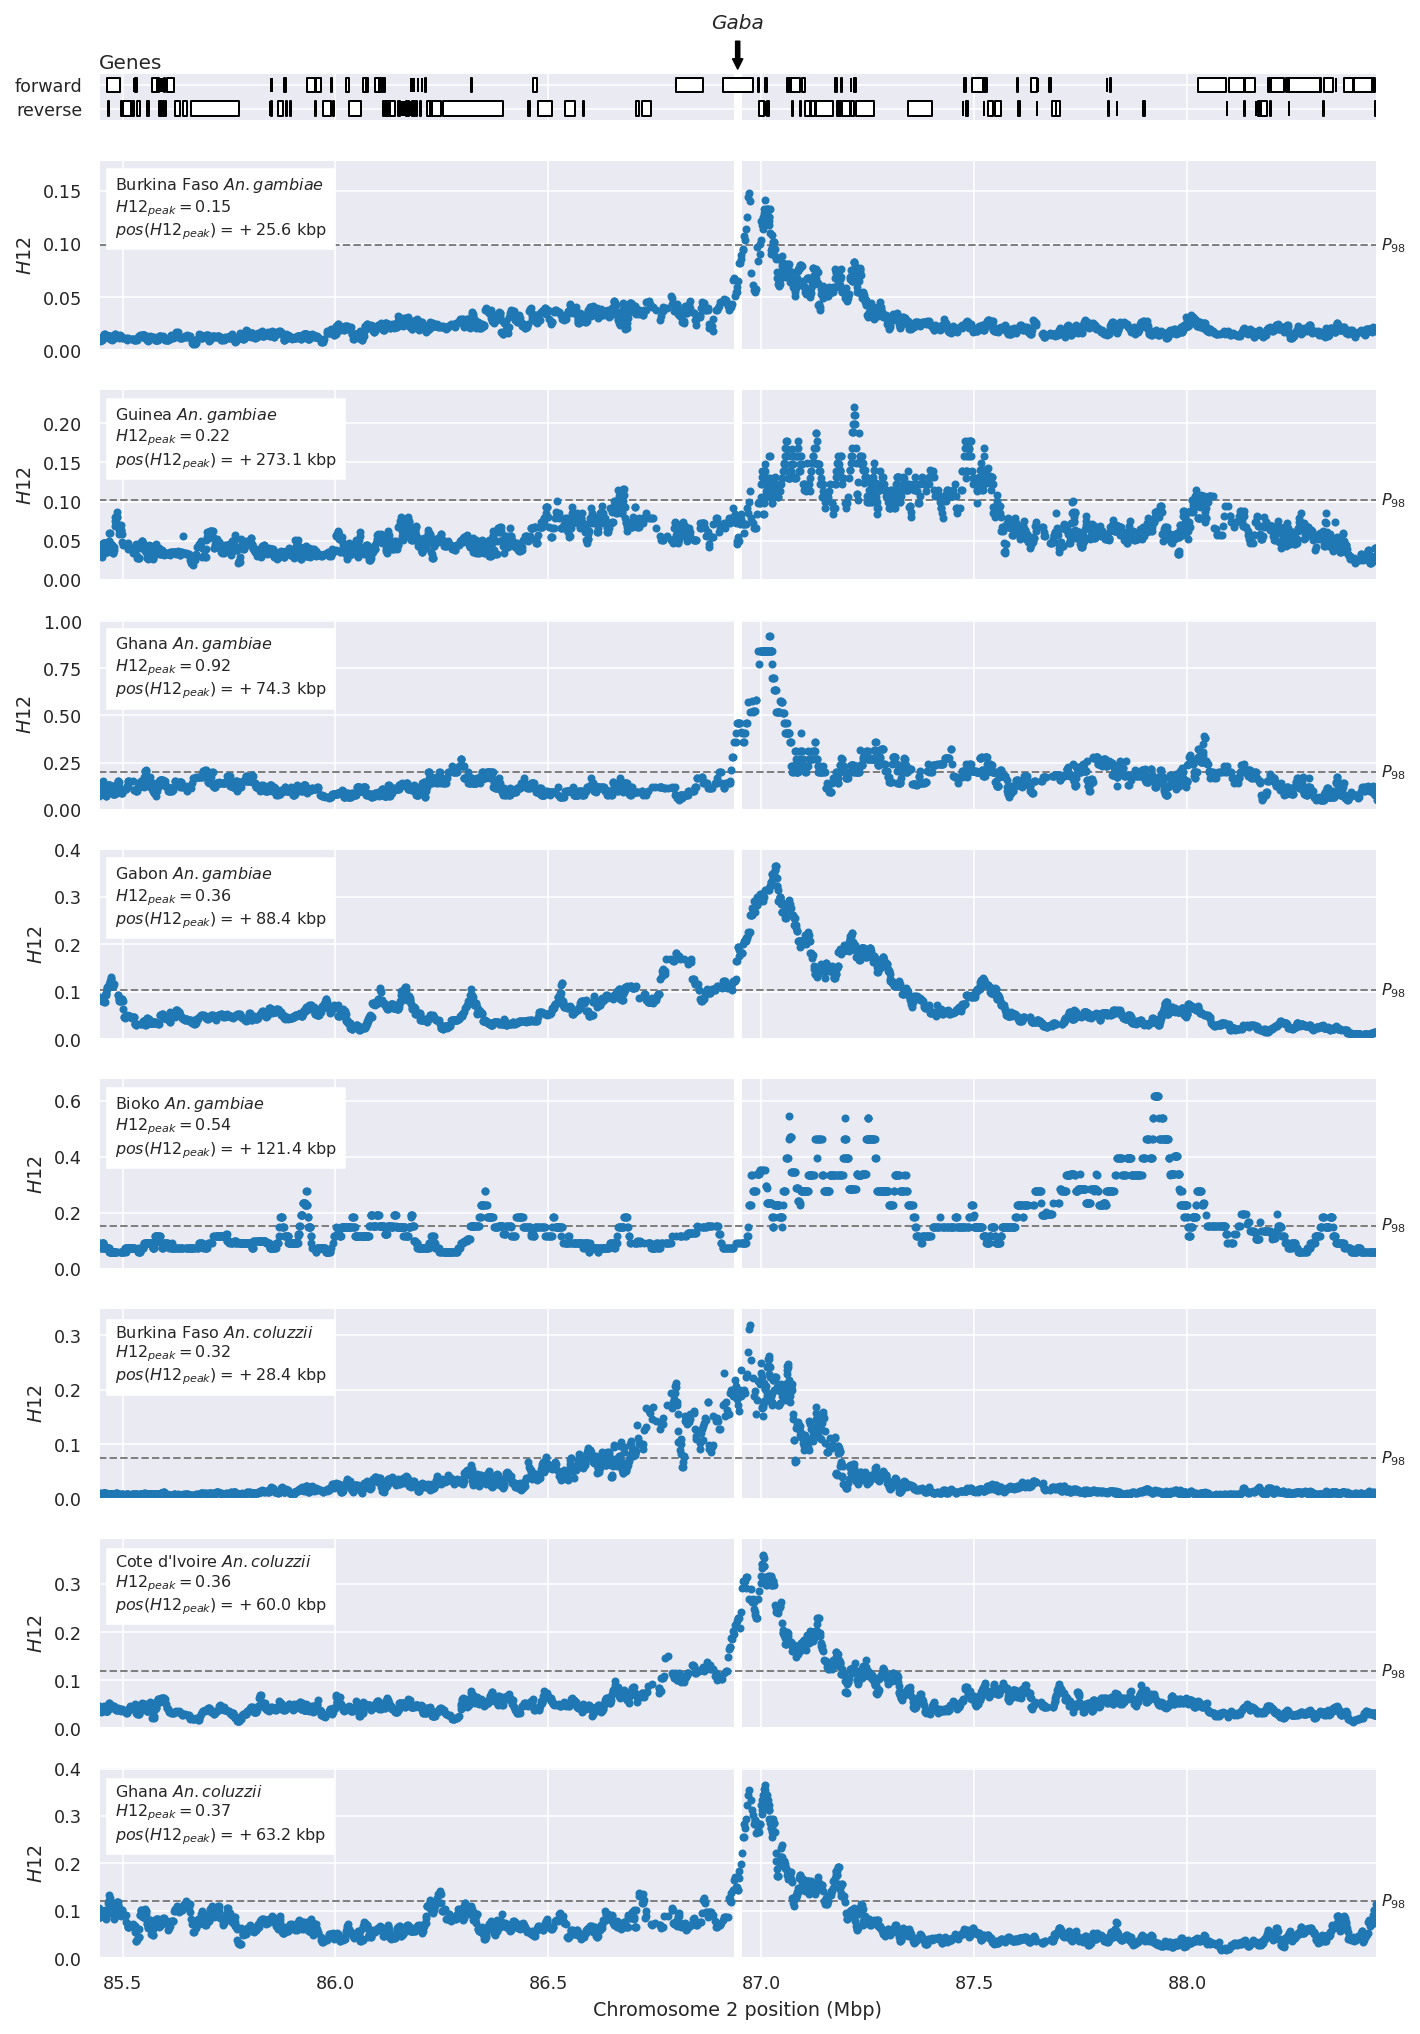

In [28]:
fig_locus(
    chromosome=gaba.chromosome, center=gaba.chromosome_center/1e6, 
    flank=1.5, label=gaba['Name'],
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
#         (plot_h12, dict(pop='cm_sav_gam')),
#         (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
#         (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
#         (plot_h12, dict(pop='ao_col')),
#         (plot_h12, dict(pop='gw')),
#         (plot_h12, dict(pop='gm')),
#         (plot_h12, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_gaba_h12.png'
);

## *Ace1*

In [29]:
ace1

seqid                            2R
source                   VectorBase
type                           gene
start                       3483099
end                         3497400
score                            -1
strand                            +
phase                            -1
Name                           Ace1
biotype              protein_coding
chromosome                        2
chromosome_start            3483099
chromosome_end              3497400
chromosome_center       3.49025e+06
Name: AGAP001356, dtype: object

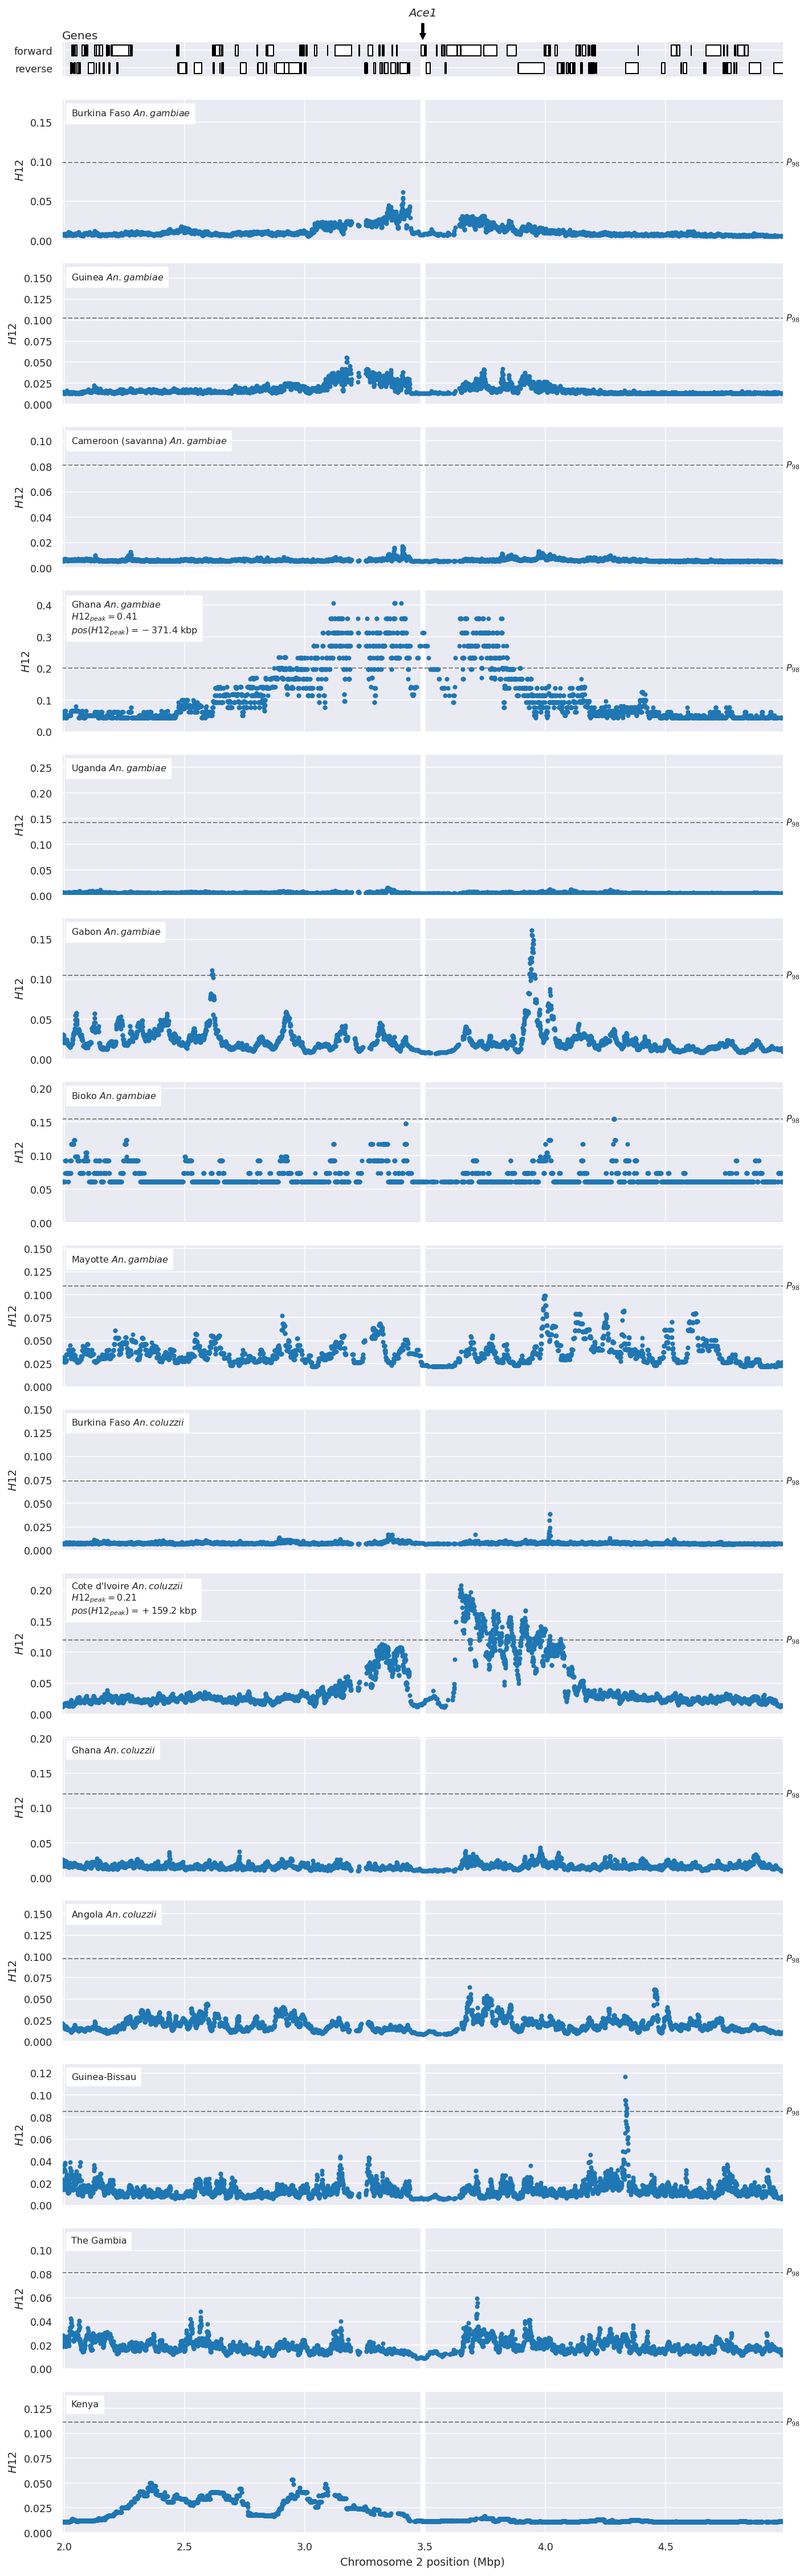

In [30]:
df_stats_ace1 = fig_locus(
    chromosome=ace1.chromosome, center=ace1.chromosome_center/1e6, 
    flank=1.5, label=ace1['Name'], track_height=2,
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
        (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
        (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
        (plot_h12, dict(pop='ke')),
    ),
)

In [31]:
df_stats_ace1

pop   h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  \
0       bf_gam       NaN       NaN        NaN          NaN           NaN   
1       gn_gam       NaN       NaN        NaN          NaN           NaN   
2   cm_sav_gam       NaN       NaN        NaN          NaN           NaN   
3       gh_gam  0.357639  0.406250   0.458333    -0.117911     -0.371430   
4       ug_gam       NaN       NaN        NaN          NaN           NaN   
5       ga_gam       NaN       NaN        NaN          NaN           NaN   
6       gq_gam       NaN       NaN        NaN          NaN           NaN   
7       fr_gam       NaN       NaN        NaN          NaN           NaN   
8       bf_col       NaN       NaN        NaN          NaN           NaN   
9       ci_col  0.183892  0.207697   0.221583     0.159213      0.159213   
10      gh_col       NaN       NaN        NaN          NaN           NaN   
11      ao_col       NaN       NaN        NaN          NaN           NaN   
12          gw       NaN       NaN        NaN          NaN           NaN   
13          gm       NaN       NaN        NaN          NaN           NaN   
14          ke       NaN       NaN        NaN          NaN           NaN   

    pos_h123_peak locus  
0             NaN  Ace1  
1             NaN  Ace1  
2             NaN  Ace1  
3       -0.371430  Ace1  
4             NaN  Ace1  
5             NaN  Ace1  
6             NaN  Ace1  
7             NaN  Ace1  
8             NaN  Ace1  
9        0.177893  Ace1  
10            NaN  Ace1  
11            NaN  Ace1  
12            NaN  Ace1  
13            NaN  Ace1  
14            NaN  Ace1

In [32]:
df_stats_ace1.describe().loc[['count', 'min', 'max']]

h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  pos_h123_peak
count  2.000000  2.000000   2.000000     2.000000      2.000000       2.000000
min    0.183892  0.207697   0.221583    -0.117911     -0.371430      -0.371430
max    0.357639  0.406250   0.458333     0.159213      0.159213       0.177893

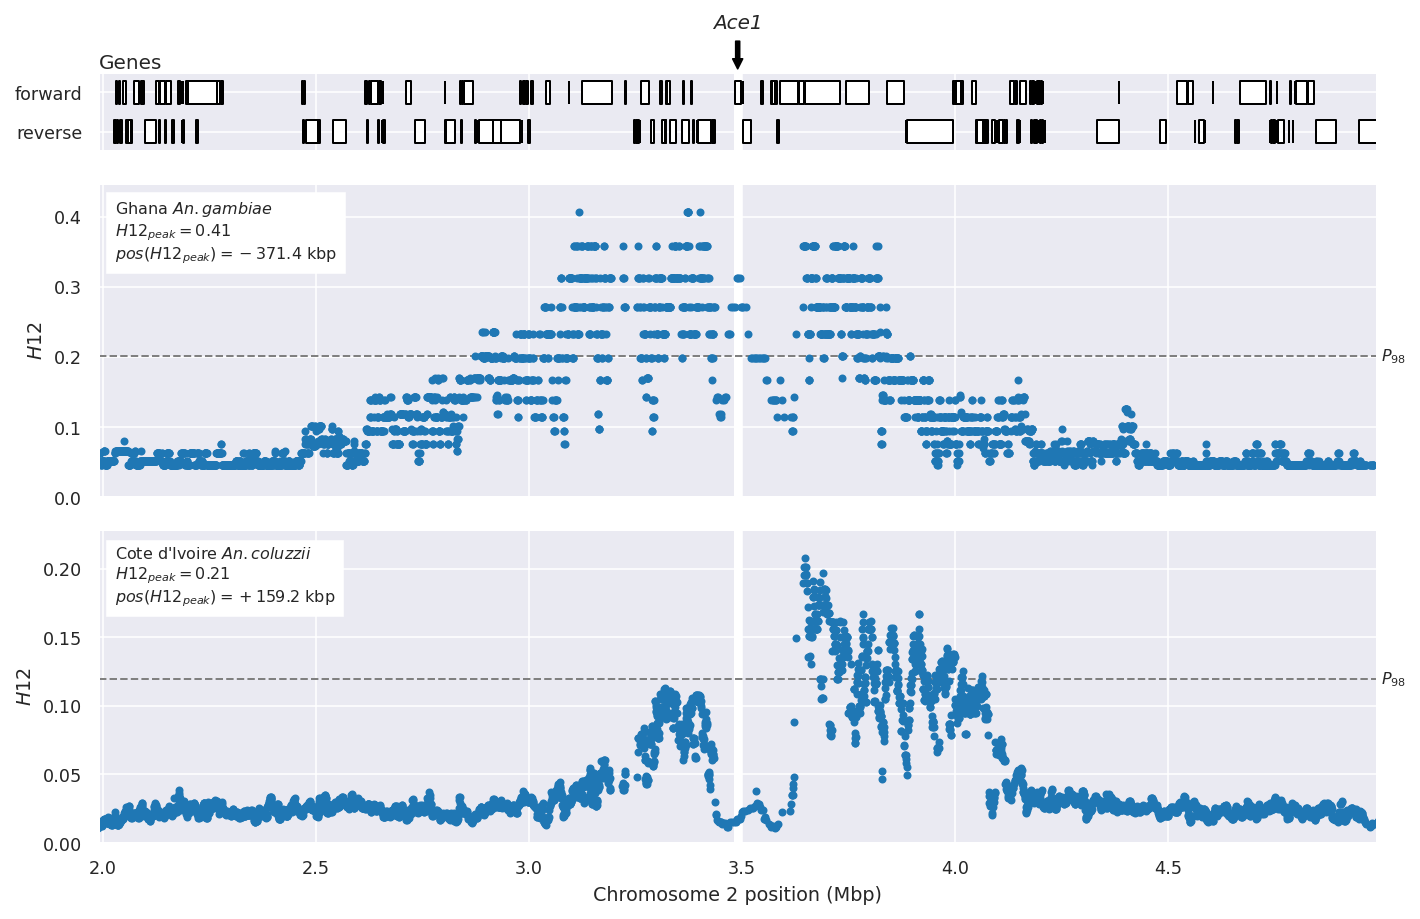

In [33]:
fig_locus(
    chromosome=ace1.chromosome, center=ace1.chromosome_center/1e6, 
    flank=1.5, label=ace1['Name'], track_height=2.5,
    tracks=(
#         (plot_h12, dict(pop='bf_gam')),
#         (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
#         (plot_h12, dict(pop='cm_sav_gam')),
#         (plot_h12, dict(pop='ug_gam')),
#         (plot_h12, dict(pop='ga_gam')),
#         (plot_h12, dict(pop='gq_gam')),
#         (plot_h12, dict(pop='fr_gam')),
#         (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
#         (plot_h12, dict(pop='gh_col')),
#         (plot_h12, dict(pop='ao_col')),
#         (plot_h12, dict(pop='gw')),
#         (plot_h12, dict(pop='gm')),
#         (plot_h12, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_ace1_h12.png'
);

## *Cyp9k1*

In [34]:
cyp9k1

seqid                             X
source                   VectorBase
type                           gene
start                      15240572
end                        15242864
score                            -1
strand                            -
phase                            -1
Name                         Cyp9k1
biotype              protein_coding
chromosome                        X
chromosome_start           15240572
chromosome_end             15242864
chromosome_center       1.52417e+07
Name: AGAP000818, dtype: object

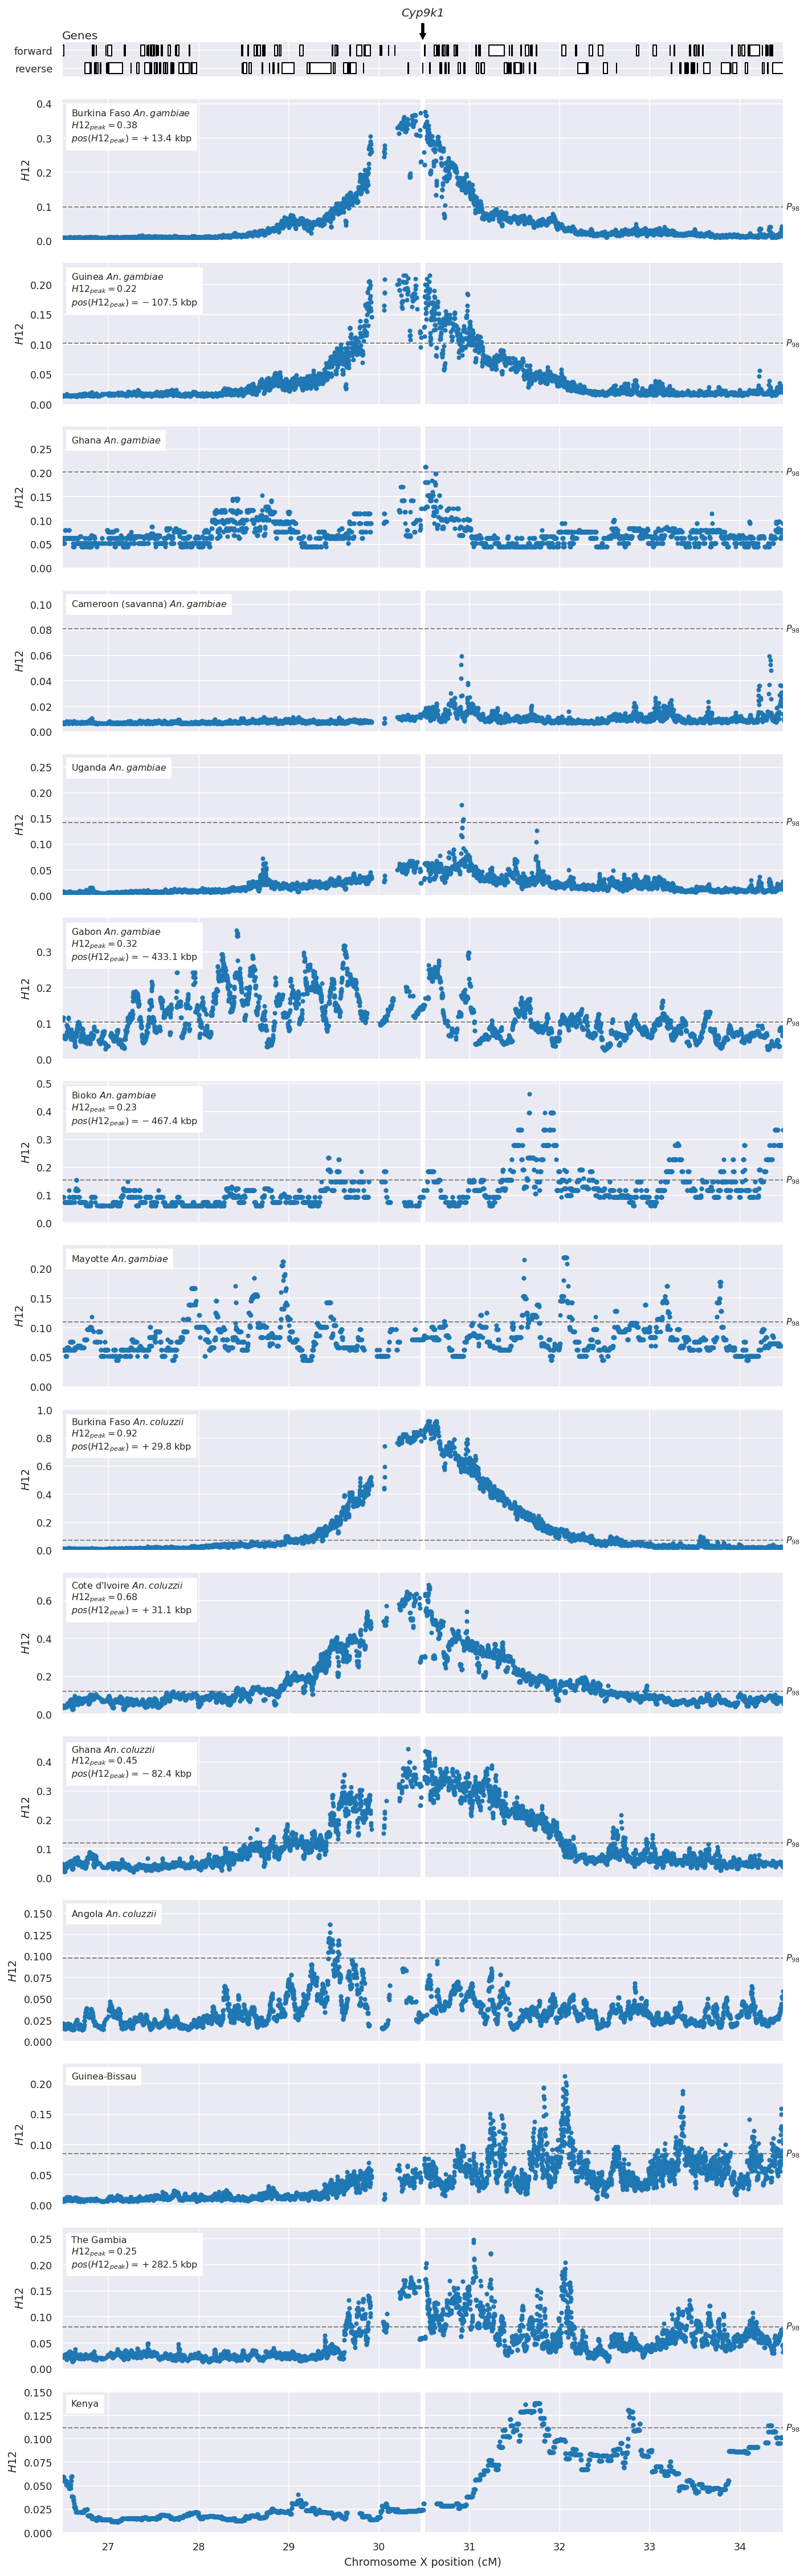

In [35]:
df_stats_cyp9k1 = fig_locus(
    chromosome=cyp9k1.chromosome, center=cyp9k1.chromosome_center/1e6, 
    flank=2, label=cyp9k1['Name'], genetic_distance=True, track_height=2,
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
        (plot_h12, dict(pop='gh_gam')),
        (plot_h12, dict(pop='cm_sav_gam')),
        (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
        (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
        (plot_h12, dict(pop='ao_col')),
        (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
        (plot_h12, dict(pop='ke')),
    ),
)

In [36]:
df_stats_cyp9k1

pop   h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  \
0       bf_gam  0.239029  0.377033   0.519603     0.013373      0.013373   
1       gn_gam  0.142500  0.215313   0.313750    -0.081534     -0.107527   
2       gh_gam       NaN       NaN        NaN          NaN           NaN   
3   cm_sav_gam       NaN       NaN        NaN          NaN           NaN   
4       ug_gam       NaN       NaN        NaN          NaN           NaN   
5       ga_gam  0.193237  0.317265   0.367255     0.040628     -0.433066   
6       gq_gam  0.154321  0.228395   0.277778     0.492843     -0.467435   
7       fr_gam       NaN       NaN        NaN          NaN           NaN   
8       bf_col  0.905478  0.918692   0.932002     0.029840      0.029840   
9       ci_col  0.374430  0.682503   0.788137    -0.087817      0.031091   
10      gh_col  0.389421  0.445620   0.520000    -0.082388     -0.082388   
11      ao_col       NaN       NaN        NaN          NaN           NaN   
12          gw       NaN       NaN        NaN          NaN           NaN   
13          gm  0.183787  0.248047   0.365444     0.376048      0.282460   
14          ke       NaN       NaN        NaN          NaN           NaN   

    pos_h123_peak   locus  
0        0.013373  Cyp9k1  
1       -0.107527  Cyp9k1  
2             NaN  Cyp9k1  
3             NaN  Cyp9k1  
4             NaN  Cyp9k1  
5        0.254115  Cyp9k1  
6       -0.467435  Cyp9k1  
7             NaN  Cyp9k1  
8        0.029840  Cyp9k1  
9        0.032855  Cyp9k1  
10       0.011651  Cyp9k1  
11            NaN  Cyp9k1  
12            NaN  Cyp9k1  
13       0.282460  Cyp9k1  
14            NaN  Cyp9k1

In [37]:
df_stats_cyp9k1.describe().loc[['count', 'min', 'max']]

h1_peak  h12_peak  h123_peak  pos_h1_peak  pos_h12_peak  pos_h123_peak
count  8.000000  8.000000   8.000000     8.000000      8.000000       8.000000
min    0.142500  0.215313   0.277778    -0.087817     -0.467435      -0.467435
max    0.905478  0.918692   0.932002     0.492843      0.282460       0.282460

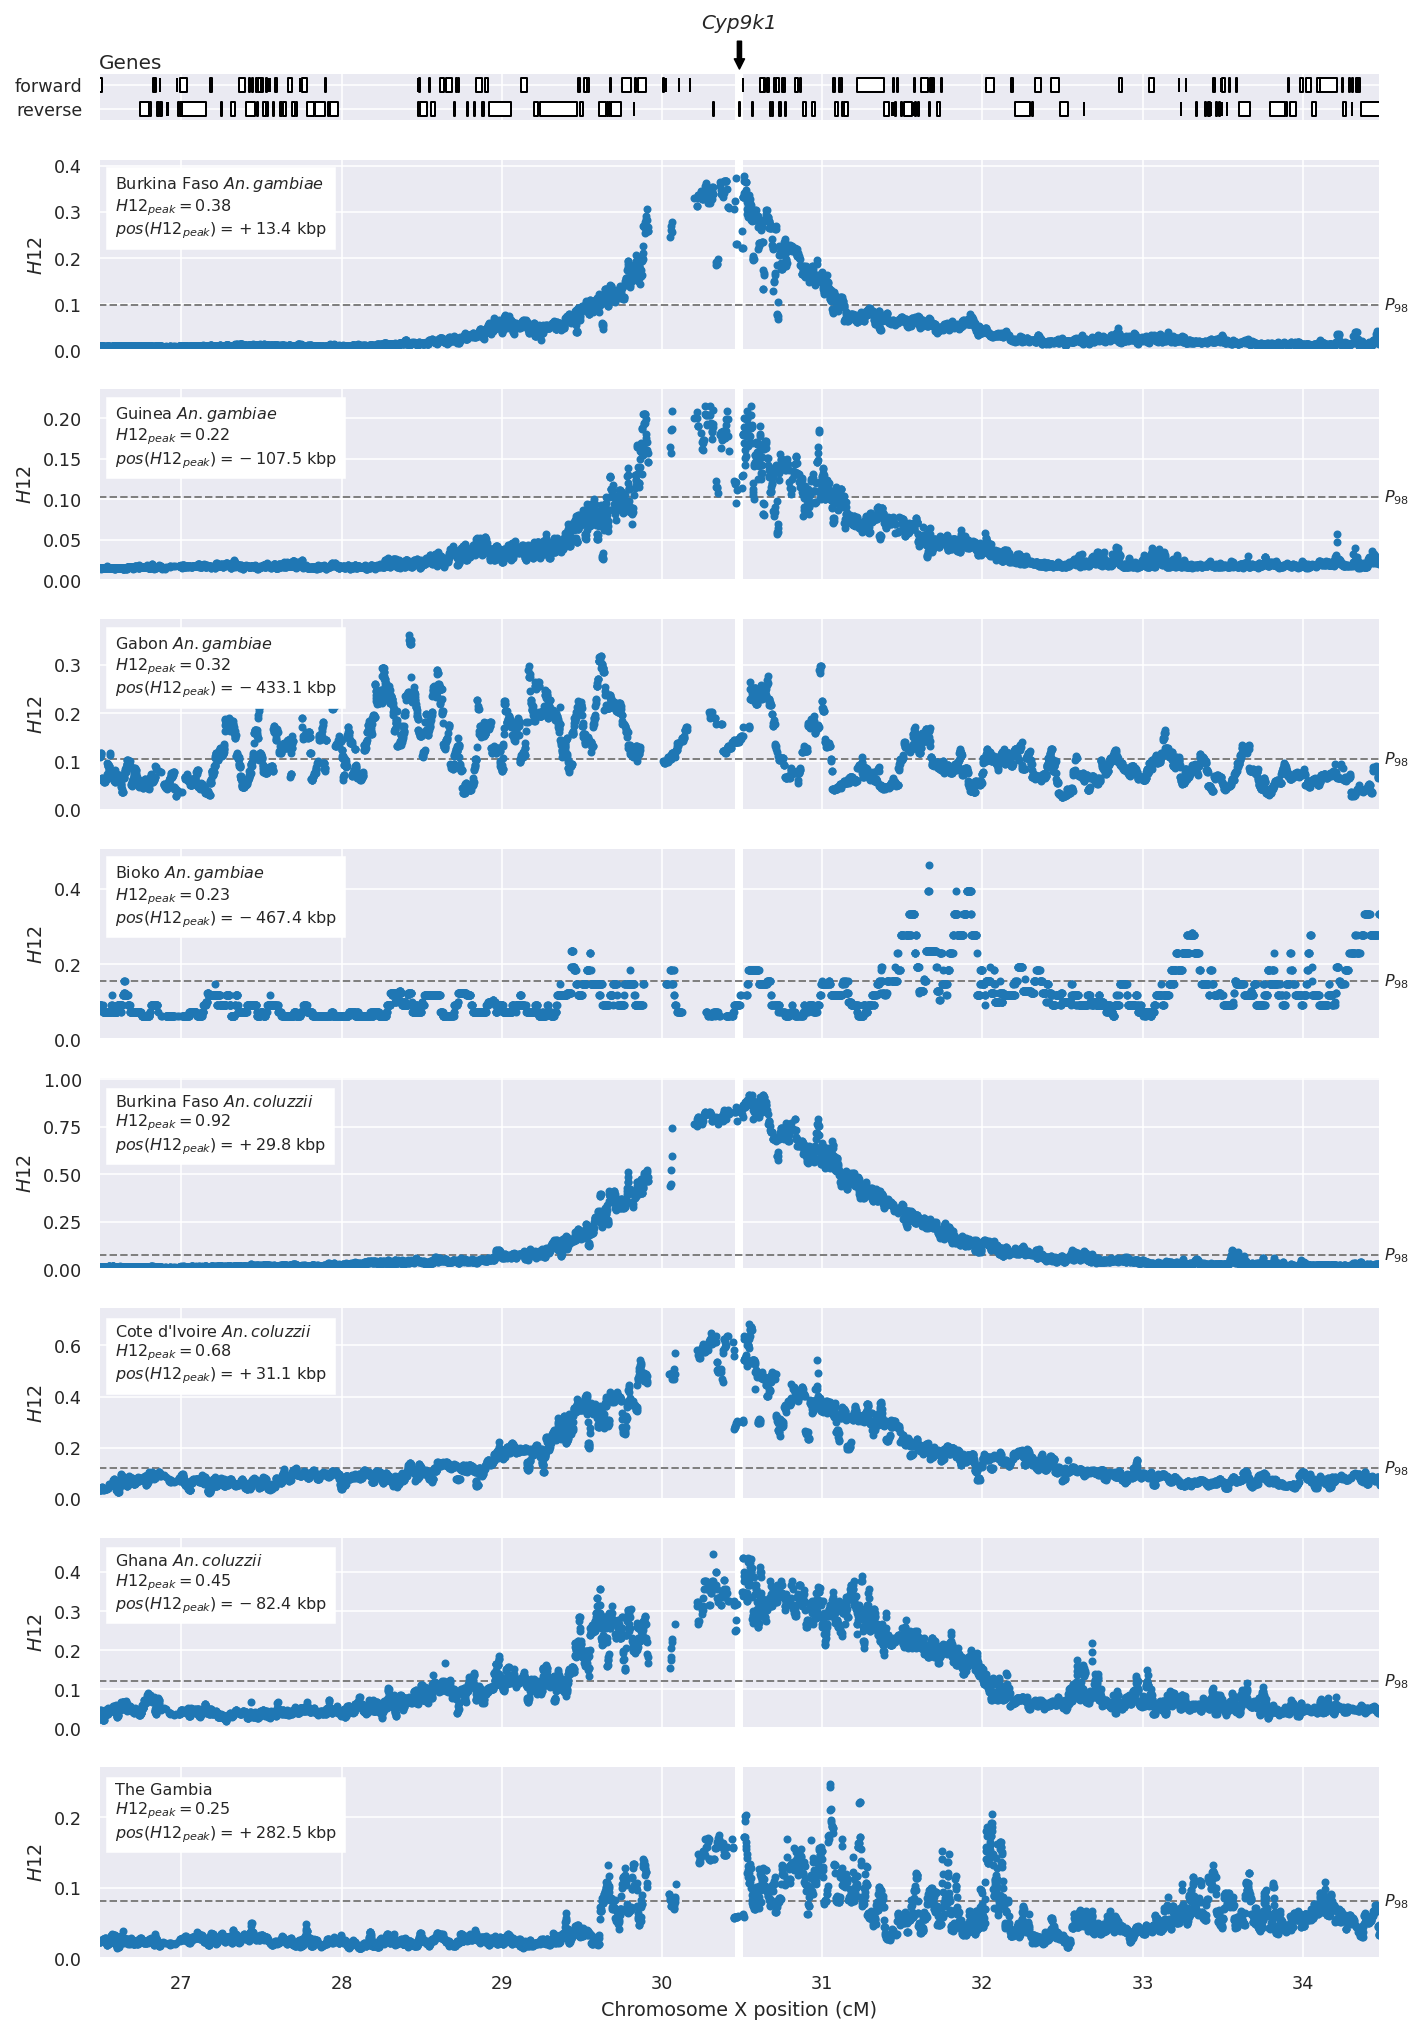

In [38]:
fig_locus(
    chromosome=cyp9k1.chromosome, center=cyp9k1.chromosome_center/1e6, 
    flank=2, label=cyp9k1['Name'], genetic_distance=True,
    tracks=(
        (plot_h12, dict(pop='bf_gam')),
        (plot_h12, dict(pop='gn_gam')),
#         (plot_h12, dict(pop='gh_gam')),
#         (plot_h12, dict(pop='cm_sav_gam')),
#         (plot_h12, dict(pop='ug_gam')),
        (plot_h12, dict(pop='ga_gam')),
        (plot_h12, dict(pop='gq_gam')),
#         (plot_h12, dict(pop='fr_gam')),
        (plot_h12, dict(pop='bf_col')),
        (plot_h12, dict(pop='ci_col')),
        (plot_h12, dict(pop='gh_col')),
#         (plot_h12, dict(pop='ao_col')),
#         (plot_h12, dict(pop='gw')),
        (plot_h12, dict(pop='gm')),
#         (plot_h12, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_cyp9k1_h12.png'
);

## Compile statistics

In [39]:
df_stats = (
    pd.concat([
        df_stats_gste2,
        df_stats_cyp6p3,
        df_stats_vgsc,
        df_stats_gaba,
        df_stats_ace1,
        df_stats_cyp9k1,
    ])
    [['locus', 'pop', 'h12_peak', 'pos_h12_peak']]
    .dropna()
)
df_stats.loc[:, 'pos_h12_peak'] = df_stats['pos_h12_peak'] * 1e3

In [40]:
def root_mean_square(s):
    return np.sqrt(np.mean(s**2))


def mean_absolute(s):
    return np.mean(np.fabs(s))


In [41]:
df_agg = df_stats.groupby('locus', sort=False).agg({
    'pop': 'count',
    'h12_peak': ['min', 'max'],
    'pos_h12_peak': ['min', 'max', mean_absolute], 
})
df_agg

pop  h12_peak           pos_h12_peak                        
       count       min       max          min       max mean_absolute
locus                                                                
Gste2      7  0.254667  0.482645     -79.2320   13.8750     20.500643
Cyp6p3     9  0.227603  0.714326     -43.2115   49.1705     32.755389
Vgsc       8  0.389053  1.000000    -341.9295  245.2025    137.869750
Gaba       8  0.148098  0.920139      25.6005  273.1255     91.807500
Ace1       2  0.207697  0.406250    -371.4300  159.2125    265.321250
Cyp9k1     8  0.215313  0.918692    -467.4350  282.4605    180.897500

In [42]:
df_agg.reset_index()

locus   pop  h12_peak           pos_h12_peak                        
          count       min       max          min       max mean_absolute
0   Gste2     7  0.254667  0.482645     -79.2320   13.8750     20.500643
1  Cyp6p3     9  0.227603  0.714326     -43.2115   49.1705     32.755389
2    Vgsc     8  0.389053  1.000000    -341.9295  245.2025    137.869750
3    Gaba     8  0.148098  0.920139      25.6005  273.1255     91.807500
4    Ace1     2  0.207697  0.406250    -371.4300  159.2125    265.321250
5  Cyp9k1     8  0.215313  0.918692    -467.4350  282.4605    180.897500

In [44]:
(df_agg
    .reset_index()
    .rename({
        'locus': 'Locus',
        'pop': 'Populations',
        'h12_peak': '$H12_{peak}$',
        'pos_h12_peak': '$pos(H12_{peak})$ (kbp)',
        'count': 'No. with peak',
        'min': 'Min',
        'max': 'Max',
        'mean_absolute': 'MAE',
    }, axis=1)
    .to_latex(
        here() / 'tables/locus_stats_h12.tex',
        escape=False,
        formatters=[
            '\\textit{{{}}}'.format,
            None,
            '{:.2f}'.format,
            '{:.2f}'.format,
            '{:+.1f}'.format,
            '{:+.1f}'.format,
            '{:.1f}'.format,
        ],
        index=False
    )
)